

# Projects on Dynamical Systems in Neurosciences

---

## Introduction

Before diving into the projects, let’s review the theoretical framework and model underpinning our work: the **Adaptive Exponential Integrate-and-Fire model (AdEx)** and the networks built from it.

---

## I. The AdEx Model

The AdEx model captures the evolution of the membrane potential in biological neurons, an essential observable for understanding their functions. These models are referred to as "neudels" (neuron models) to avoid conflating them with actual neurons.


### Core Equations of AdEx

1. **Basic Integrate-and-Fire Model**  
   Describes the dynamics of the membrane potential based on input currents:  
   $$ 
   C \frac{dV}{dt} = I_{\text{inputs}} 
   $$
   where:
   - $C$: Membrane capacitance  
   - $V$: Membrane potential  
   - $ I_\text{inputs}$ : Input current  


2. **Incorporating Leak Current**  
   Adds a leak term to account for the resting membrane potential:  
   $$ 
   C \frac{dV}{dt} = g_L (E_L - V) + I_{\text{inputs}} 
   $$
   where:
   - $g_L$: Leak conductance  
   - $E_L$: Leak reversal potential  


3. **Exponential Dynamics for Fast Sodium Channels**  
   Introduces an exponential term to model sodium channel activation:  
   $$ 
   C \frac{dV}{dt} = g_L (E_L - V) + g_L \Delta_T \exp \left( \frac{V - V_T}{\Delta_T} \right) + I_{\text{inputs}} 
   $$
   where:
   - $V_T$: Threshold potential  
   - ${\Delta_T}$: Slope parameter for the exponential rise  


4. **Including Frequency Adaptation**  
   Models adaptation through an additional variable \( w \):  
   $$
   \begin{aligned}
   C \frac{dV}{dt} &= g_L (E_L - V) + g_L \Delta_T \exp \left( \frac{V - V_T}{\Delta_T} \right) - w + I_{\text{inputs}} \\
   \tau_w \frac{dw}{dt} &= a(V - E_L) - w
   \end{aligned}
   $$
   where:
   - $w$: Adaptation current  
   - $a$: Adaptive channel conductance  
   - $\tau_w\$: Adaptation time constant  


5. **Spike Reset Mechanism**  
   Resets the potential and updates the adaptation current after a spike is detected:  
   $$
   V \to V_R \quad \text{and} \quad w \to w + b
   $$
   where:
   - $V_R$: Reset potential  
   - $b$: Adaptation increment  

---

## II. Network of AdEx Neudels

Networks are constructed by connecting neudels via synaptic interactions. In this model, the synaptic activity is **conductance-based**, where spikes modify conductance rather than directly generating currents.

### Synaptic Current Model  
   Models the synaptic current as a function of excitatory and inhibitory conductances:  
   $$
   I_{\text{syn}} = g_E (E_E - V) + g_I (E_I - V)
   $$
   where:
   - $g_E$, $g_I$: Excitatory and inhibitory conductances  
   - $E_E$, $E_I$: Reversal potentials for excitatory and inhibitory synapses  

The dynamics of conductance decay follow:  
$$
\frac{dg_{E/I}}{dt} = -\frac{g_{E/I}}{\tau_{\text{syn}}}
$$
where:
- $ \tau_{\text{syn}} $ : Synaptic time constant  
- $ Q_E, Q_I $: Conductance increments per spike  

### Network Structure  
Neudels interact through spikes and can be connected using controlled structures or probabilistic connection schemes. These networks often exhibit high-dimensional dynamics, where classical low-dimensional techniques like phase portraits are impractical. However, with appropriate measurements and analysis, valuable insights can still be gleaned.


---

# First Project: AdEx on the Test Bed (The Birth of Chaos)

---

## 1. Characterization of the Single Model

The primary objective of a reduced neudel is to reproduce the time evolution of the membrane potential observed in biological neurons. The fewer variables in the model, the less computational resources are required, but a single variable alone cannot reproduce complex patterns like bursts. This is why the **AdEx model** uses two variables, allowing it to both conserve computational efficiency and visualize phase space in two dimensions.

We can use the `AdEx NC.py` code to visualize the model, observing the nullclines for each variable and the trajectory of a simulation. By adjusting parameters like $I_s$, $V_{\text{reset}}$, $E_L$, and others, you can observe how they influence the dynamics of the model. This approach provides an intuitive understanding of the system. By fine-tuning parameters and modifying the topology of phase space, it's possible to obtain the desired patterns. However, this "fine-tuning" approach, if not done carefully, can lead us further from biological realism.

### Methodological summary :

1. **Single-neuron phase portraits** can be helpful in understanding the initial behavior of individual neurons but need to be extended to network dynamics through simulations (like the ones you are performing with the `Brian2` library) to understand collective behavior.
   
2. **For different levels of interaction**, we will explore this by simulating networks with varying synaptic strengths and observing the transitions between independent firing, synchronized oscillations, and chaotic behavior.
   
3. **Global system characterization** can be done by recording population firing rates, calculating phase synchronization, and analyzing the overall network behavior using tools like spectral analysis or attractor reconstruction.

4. **Increasing the number of neurons** will require careful examination of the new emergent properties and feedback loops. We will do this by varying the size of the population and comparing the global dynamics for different sizes (e.g., by changing `Nb1` and `Nb2` in our simulations).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
import ipywidgets as widgets
from IPython.display import display

In [4]:
# Restart simulation (to avoid some problems btw runs)

start_scope()

In [5]:
# Définition des paramètres du modèle AdEx (avec préfixe pour éviter les conflits)
params = {
    'Cm': 200e-12,    # Capacité membranaire
    'gl': 10e-9,      # Conductance de fuite
    'El_global': -70e-3,  # Potentiel de fuite
    'Vt': -50e-3,     # Seuil de déclenchement
    'Dt': 2e-3,       # Paramètre exponentiel
    'a': 2e-9,        # Conductance adaptative
    'tau_w': 100e-3,  # Temps d'adaptation
    'Is_global': 2e-11,  # Courant d'entrée
    'Vreset_global': -65e-3,  # Potentiel de réinitialisation
    'b': 60e-12       # Incrément d'adaptation après un spike
}

# Création des équations du modèle AdEx
eqs = '''
dv/dt = (-gl * (v - El) + gl * Dt * exp((v - Vt) / Dt) - w + Is) / Cm : volt
dw/dt = (a * (v - El) - w) / tau_w : amp
Cm : farad
gl : siemens
El : volt
Vt : volt
Dt : volt
a : siemens
tau_w : second
Is : amp
Vreset : volt
b : amp
'''

In [6]:
# Création du groupe de neurones
group = NeuronGroup(1, eqs, threshold='v > -40*mV', reset='v = Vreset; w += b', method='heun')

# Initialisation des variables
group.v = -65e-3 * volt
group.w = 0.0 * amp
group.Cm = params['Cm'] * farad
group.gl = params['gl'] * siemens
group.El = params['El_global'] * volt
group.Vt = params['Vt'] * volt
group.Dt = params['Dt'] * volt
group.a = params['a'] * siemens
group.tau_w = params['tau_w'] * second
group.Is = params['Is_global'] * amp
group.Vreset = params['Vreset_global'] * volt
group.b = params['b'] * amp

# Moniteur d'état
monitor = StateMonitor(group, ['v', 'w'], record=True)

# Création d'un réseau et ajout des objets
net = Network()
net.add(group)
net.add(monitor)

In [7]:
# Fonction pour calculer les nullclines
def compute_nullclines(Is, El):
    v_vals = np.linspace(-0.08, -0.04, 500)  # Domaine de v
    w_nullcline_v = -params['gl'] * (v_vals - El) + \
                    params['gl'] * params['Dt'] * np.exp((v_vals - params['Vt']) / params['Dt']) + \
                    Is
    w_nullcline_w = params['a'] * (v_vals - El)
    return v_vals, w_nullcline_v, w_nullcline_w

# Fonction de mise à jour des paramètres
def update_params(Is_global, Vreset_global, El_global):
    params['Is_global'] = Is_global
    params['Vreset_global'] = Vreset_global
    params['El_global'] = El_global

    # Mise à jour des variables du groupe
    group.Is = params['Is_global'] * amp
    group.Vreset = params['Vreset_global'] * volt
    group.El = params['El_global'] * volt

    # Simulation
    group.v = -65e-3 * volt
    group.w = 0.0 * amp
    net.run(1 * second)  # Simulation avec le réseau

    # Recalcule et affichage
    v_vals, w_nullcline_v, w_nullcline_w = compute_nullclines(Is_global, El_global)
    plt.figure(figsize=(10, 8))
    
    # Tracé des nullclines
    plt.plot(v_vals * 1e3, w_nullcline_v * 1e12, 'b', label=r'$\frac{dv}{dt}=0$ (Nullcline de $v$)')
    plt.plot(v_vals * 1e3, w_nullcline_w * 1e12, 'k', label=r'$\frac{dw}{dt}=0$ (Nullcline de $w$)')
    
    # Trajectoire simulée
    plt.plot(monitor.v[0] * 1e3, monitor.w[0] * 1e12, 'r', label='Trajectoire simulée')
    
    # Champ de vecteurs
    v_grid, w_grid = np.meshgrid(
        np.linspace(-0.08, -0.04, 20),
        np.linspace(-0.5e-10, 1.5e-10, 20)
    )
    v_dot = (-params['gl'] * (v_grid - El_global) +
             params['gl'] * params['Dt'] * np.exp((v_grid - params['Vt']) / params['Dt']) - w_grid +
             Is_global) / params['Cm']
    w_dot = (params['a'] * (v_grid - El_global) - w_grid) / params['tau_w']
    plt.quiver(v_grid * 1e3, w_grid * 1e12, v_dot, w_dot, color='gray', alpha=0.5, scale=1e11)

    # Annotations
    plt.annotate('Point fixe', xy=(-60, 0), xytext=(-65, 0.1),
                 arrowprops=dict(facecolor='red', arrowstyle='->'))
    
    # Labels et légende
    plt.xlabel('$v$ (mV)')
    plt.ylabel('$w$ (pA)')
    plt.title('Portrait de phase du modèle AdEx')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Tracé des évolutions temporelles
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(monitor.t / ms, monitor.v[0] / mV)
    plt.xlabel('Temps (ms)')
    plt.ylabel('Potentiel de membrane (mV)')
    plt.title('Evolution temporelle de v')

    plt.subplot(1, 2, 2)
    plt.plot(monitor.t / ms, monitor.w[0] / pA)
    plt.xlabel('Temps (ms)')
    plt.ylabel('Variable d’adaptation (pA)')
    plt.title('Evolution temporelle de w')
    plt.tight_layout()
    plt.show()

# Création des widgets interactifs
Is_slider = widgets.FloatSlider(value=params['Is_global'], min=0, max=10e-10, step=0.1e-10, description='Is (A):')
Vreset_slider = widgets.FloatSlider(value=params['Vreset_global'], min=-70e-3, max=-60e-3, step=1e-3, description='Vreset (V):')
El_slider = widgets.FloatSlider(value=params['El_global'], min=-70e-3, max=-60e-3, step=1e-3, description='El (V):')

interactive_widget = widgets.interactive(update_params, Is_global=Is_slider, Vreset_global=Vreset_slider, El_global=El_slider)
display(interactive_widget)


interactive(children=(FloatSlider(value=2e-11, description='Is (A):', max=1e-09, step=1e-11), FloatSlider(valu…

---

## 2. Effects of Interactions

Now that you are familiar with the dynamics of a single AdEx neudel, we can focus on the interaction between multiple neudels. Let’s begin with two. Use the `AdEx interact.py` code to explore this. You can adjust the number of neudels with inhibitory or excitatory effects and modify parameters related to the strength of the coupling, such as \( Q_e \) and \( Q_i \).

Through experimentation, you can observe how the overall system can evolve into different types of dynamical regimes. This leads to several important questions, such as:

- What can we infer about the coupled system from the phase portrait of a single neudel?
- Are there certain levels of input or interaction where such a description remains relevant for understanding the global dynamics?
- How can we characterize the behavior of the global system? What happens if we increase the number of neudels in the network?


In [11]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Initialisation
start_scope()

# Paramètres du modèle AdEx
defaultclock.dt = 0.1 * ms

def plot_adex_single_neuron(Is=0.1):
    # Paramètres neuronaux
    Cm = 200 * pF
    gl = 10 * nS
    El = -65 * mV
    Vt = -50 * mV
    Dt = 2 * mV
    a = 2 * nS
    tau_w = 200 * ms
    b = 0.04 * nA
    Vreset = -60 * mV

    # Équations AdEx (avec Is comme paramètre dynamique)
    eqs = '''
    dv/dt = (gl * (El - v) + gl * Dt * exp((v - Vt) / Dt) - w + Is) / Cm : volt
    dw/dt = (a * (v - El) - w) / tau_w : amp
    Is : amp
    '''

    # Création d’un neurone
    G = NeuronGroup(1, eqs, threshold='v > -40 * mV', reset='v = Vreset; w += b', method='euler')
    G.v = El
    G.w = 0 * pA
    G.Is = Is * nA  # Définir la valeur initiale de Is

    # Enregistrement des variables
    M = StateMonitor(G, ['v', 'w'], record=True)

    # Simulation
    run(300 * ms)

    # Tracé des nullclines
    v_vals = np.linspace(-70, -40, 500) * mV
    w_nullcline = (gl * (El - v_vals) + gl * Dt * np.exp((v_vals - Vt) / Dt) + Is * nA) / a
    v_nullcline = a * (v_vals - El)

    plt.figure(figsize=(10, 6))
    plt.plot(v_vals / mV, w_nullcline / pA, label="w-nullcline", color="blue")
    plt.plot(v_vals / mV, v_nullcline / pA, label="v-nullcline", color="orange")
    plt.plot(M.v[0] / mV, M.w[0] / pA, label="Trajectory", color="green")
    plt.scatter(M.v[0, -1] / mV, M.w[0, -1] / pA, color="red", label="Final Point")
    plt.xlabel("Membrane Potential (V) [mV]")
    plt.ylabel("Adaptation Variable (w) [pA]")
    plt.title(f"AdEx Phase Portrait (Is = {Is} nA)")
    plt.legend()
    plt.grid()
    plt.show()

# Utilisation de widgets interactifs
interact(plot_adex_single_neuron, Is=FloatSlider(value=0.1, min=0.05, max=0.5, step=0.05, description="Is (nA)"))


interactive(children=(FloatSlider(value=0.1, description='Is (nA)', max=0.5, min=0.05, step=0.05), Output()), …

<function __main__.plot_adex_single_neuron(Is=0.1)>

--## Start simulation for Nb1=2 and Nb2=2 ##--
--## End simulation ##--


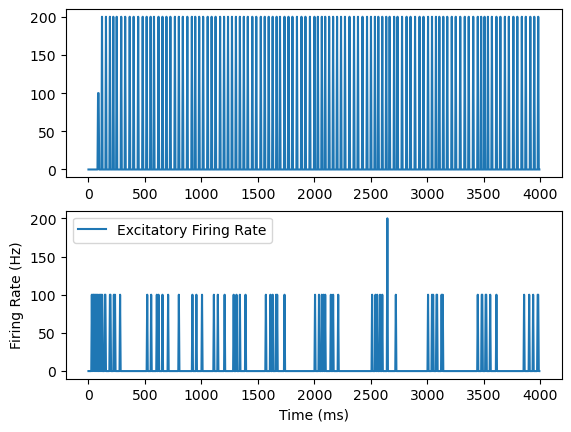

--## Start simulation for Nb1=2 and Nb2=10 ##--
--## End simulation ##--


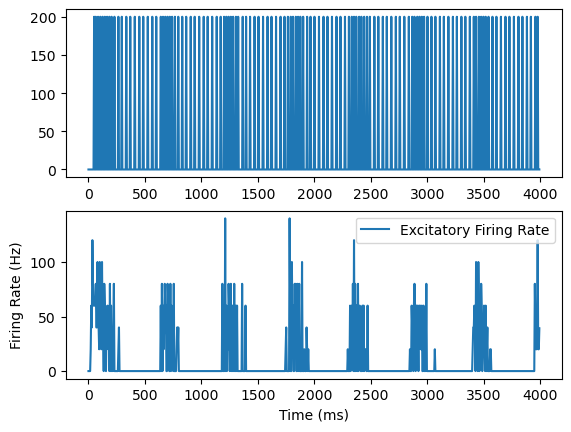

--## Start simulation for Nb1=2 and Nb2=50 ##--
--## End simulation ##--


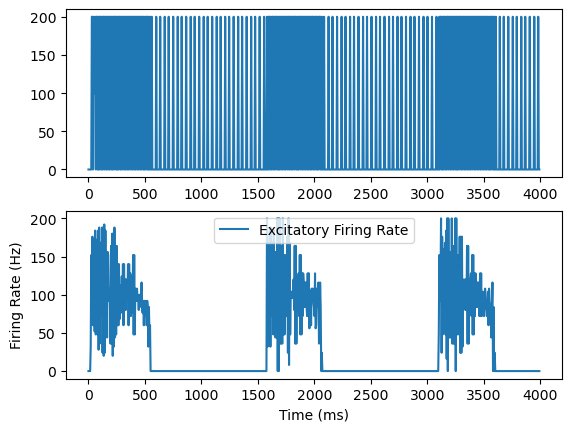

--## Start simulation for Nb1=10 and Nb2=2 ##--
--## End simulation ##--


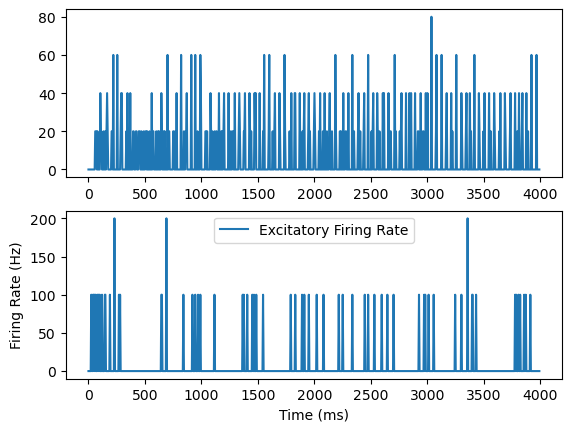

--## Start simulation for Nb1=10 and Nb2=10 ##--
--## End simulation ##--


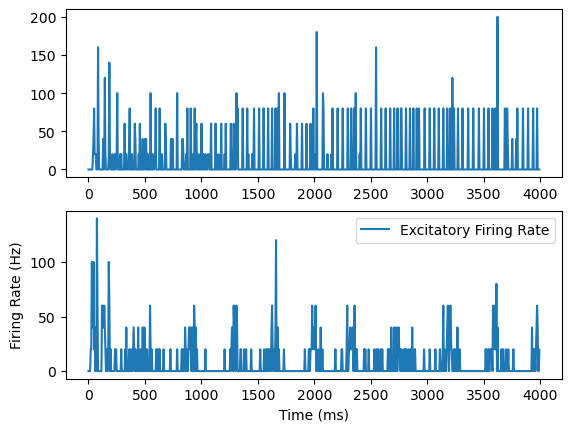

--## Start simulation for Nb1=10 and Nb2=50 ##--
--## End simulation ##--


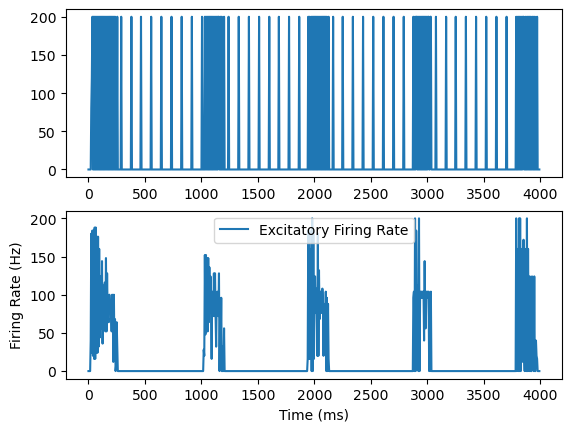

--## Start simulation for Nb1=50 and Nb2=2 ##--
--## End simulation ##--


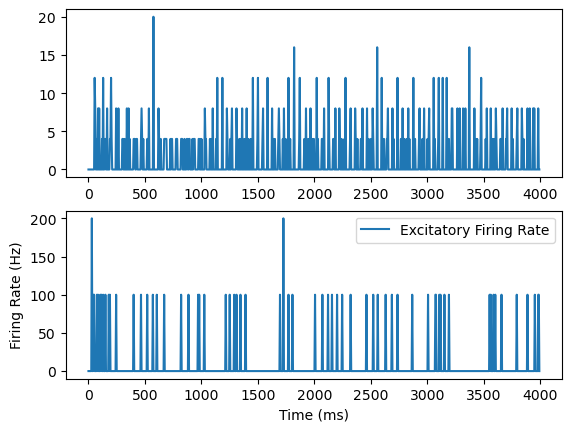

--## Start simulation for Nb1=50 and Nb2=10 ##--
--## End simulation ##--


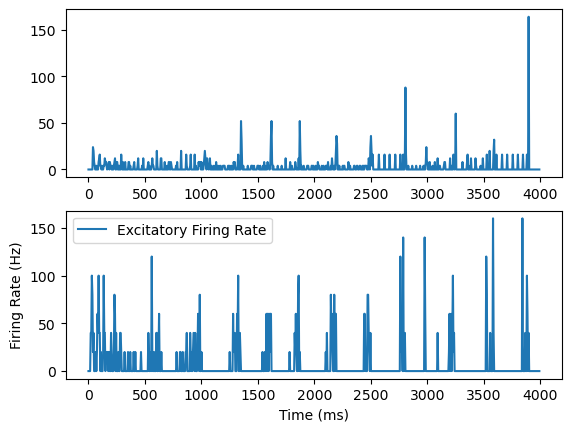

--## Start simulation for Nb1=50 and Nb2=50 ##--
--## End simulation ##--


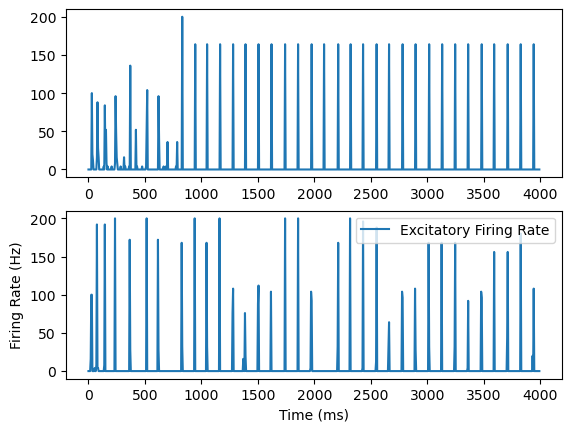

In [24]:
from brian2 import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

%matplotlib inline

#########################
# Simulation conditions #-------------------------------------------------------------------------
#########################

DT = 0.1  # time step
defaultclock.dt = DT * ms
TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

###############
# Equations ###----------------------------------------------------------------------------------
###############
eqs = '''
# Neuron dynamics:
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
# Model of synapses:
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
# Parameters:
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

##################
# Define a function to initialize and run the simulation for each combination of neurons #
##################
def bin_array(data, bin_size, time_array):
    bins = np.arange(time_array[0], time_array[-1], bin_size)
    binned_data = binned_statistic(time_array, data, statistic='mean', bins=bins)[0]
    return bins[:-1], binned_data

def run_simulation(Nb1, Nb2):
    # Define neuron groups
    if Nb1 != 0:
        # Inhibitory neurons
        G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
        for k in range(len(G_inh.v)):
            G_inh.v[k] = random.uniform(-55, -65) * mV

        G_inh.w = 0.0 * pA
        G_inh.GsynI = 0.0 * nS
        G_inh.GsynE = 0.0 * nS
        # Parameter values for inhibitory neurons
        b1 = 0.0 * pA
        G_inh.Cm = 200.0 * pF
        G_inh.gl = 10.0 * nS
        G_inh.El = -65.0 * mV
        G_inh.Vt = -55.0 * mV
        G_inh.Dt = 5.0 * mV
        G_inh.tau_w = 500.0 * ms
        G_inh.a = 0.0 * nS
        G_inh.Is = .06 * nA
        G_inh.Ee = 0.0 * mV
        G_inh.Ei = -80.0 * mV
        G_inh.Tsyn = 5.0 * ms

    if Nb2 != 0:
        # Excitatory neurons
        G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
        for k in range(len(G_exc.v)):
            G_exc.v[k] = random.uniform(-55, -65) * mV

        G_exc.w = 0.0 * pA
        G_exc.GsynI = 0.0 * nS
        G_exc.GsynE = 0.0 * nS
        # Parameter values for excitatory neurons
        b2 = 10.0 * pA
        G_exc.Cm = 200.0 * pF
        G_exc.gl = 10.0 * nS
        G_exc.El = -65.0 * mV
        G_exc.Vt = -55.0 * mV
        G_exc.Dt = 5.0 * mV
        G_exc.tau_w = 500.0 * ms
        G_exc.a = 2.0 * nS
        G_exc.Is = .120 * nA
        G_exc.Ee = 0.0 * mV
        G_exc.Ei = -80.0 * mV
        G_exc.Tsyn = 5.0 * ms

    ##################
    # Synapses setup #
    ##################
    Qi = 1.5 * nS
    Qe = 0.5 * nS

    if Nb1 != 0:
        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
        S_11.connect(p=1)

    if Nb2 != 0:
        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
        S_22.connect(p=1)

    if Nb1 != 0 and Nb2 != 0:
        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
        S_21.connect(p=1)
        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
        S_12.connect(p=1)

    ##################
    # Recording tools #
    ##################
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

    ##################
    # Run simulation #
    ##################
    print(f'--## Start simulation for Nb1={Nb1} and Nb2={Nb2} ##--')
    run(duration)
    print('--## End simulation ##--')

    ##################
    # Data processing #
    ##################
    BIN = 5
    time_array = arange(int(TotTime / DT)) * DT

    LVG1 = [array(M2G1[a].v / mV) for a in range(Nb1)]
    LwG1 = [array(M3G1[a].w / mamp) for a in range(Nb1)]
    LVG2 = [array(M2G2[a].v / mV) for a in range(Nb2)]
    LwG2 = [array(M3G2[a].w / mamp) for a in range(Nb2)]

    LfrG1 = np.array(FRG1.rate / Hz)
    TimBinned, popRateG_inh = bin_array(LfrG1, BIN, time_array)
    LfrG2 = np.array(FRG2.rate / Hz)
    TimBinned, popRateG_exc = bin_array(LfrG2, BIN, time_array)

    ##################
    # Visualization #
    ##################
    plt.figure()
    plt.subplot(211)
    plt.plot(TimBinned, popRateG_inh, label="Inhibitory Firing Rate")
    plt.subplot(212)
    plt.plot(TimBinned, popRateG_exc, label="Excitatory Firing Rate")
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.show()

##################
# Experiment with different number of neurons
##################
Nb1_values = [2, 10, 50]
Nb2_values = [2, 10, 50]

for Nb1 in Nb1_values:
    for Nb2 in Nb2_values:
        run_simulation(Nb1, Nb2)


--## Start simulation for Nb1=2 and Nb2=2 ##--


WARNING    The object 'neurongroup_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/1c/m8yz738x35q9s40pmh1lqdb40000gn/T/ipykernel_96903/1919947356.py', line 71, in run_simulation
    G_inh = NeuronGroup(0, eqs) [brian2.core.base.unused_brian_object]


--## End simulation ##--


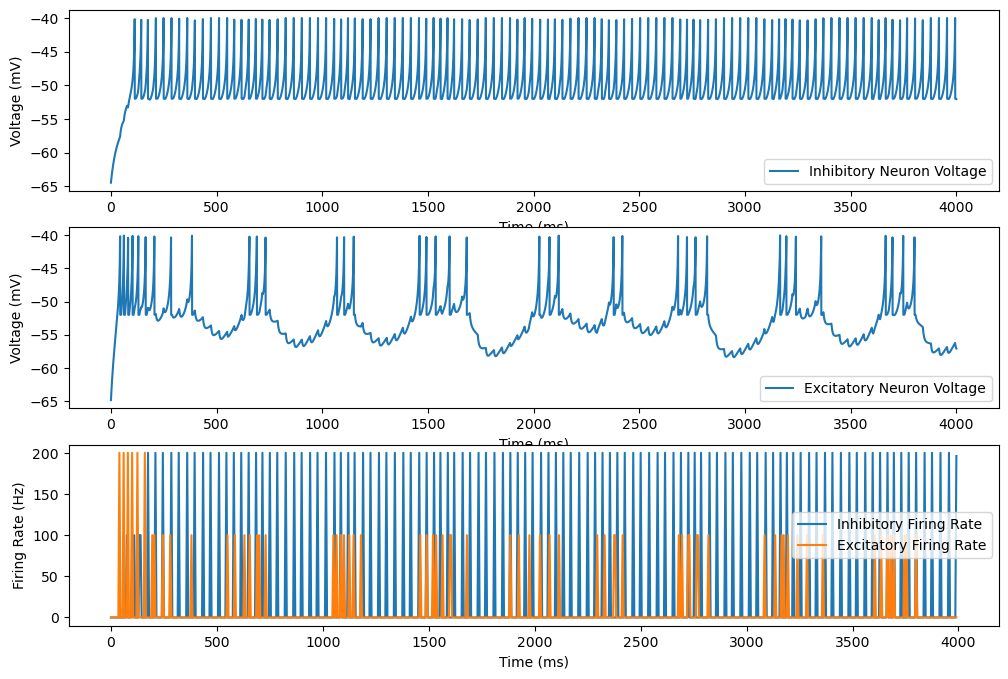

--## Start simulation for Nb1=2 and Nb2=10 ##--
--## End simulation ##--


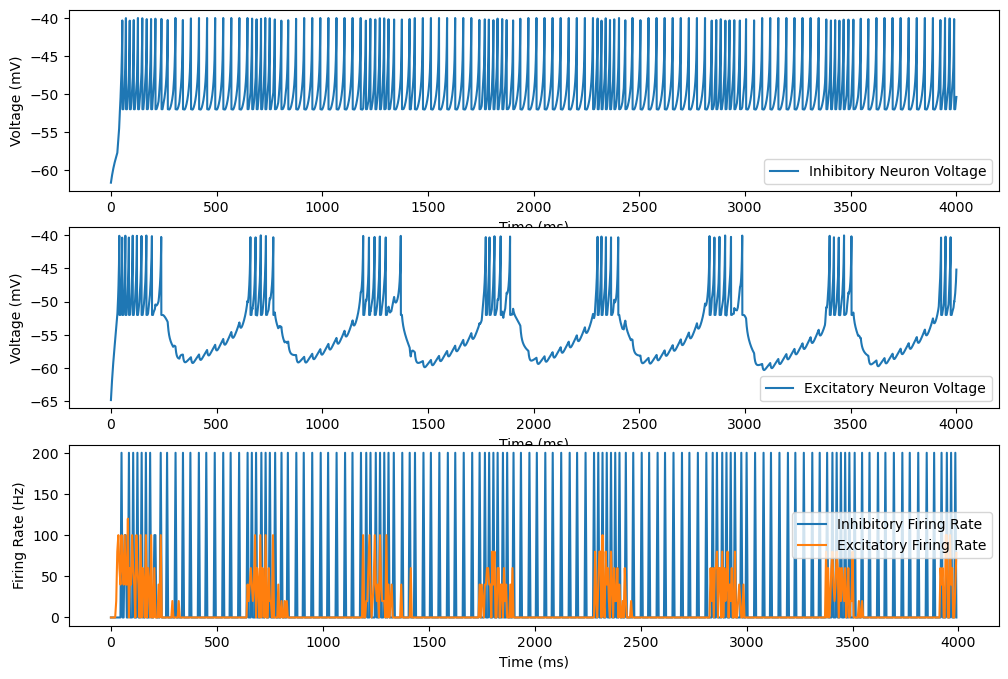

--## Start simulation for Nb1=2 and Nb2=50 ##--
--## End simulation ##--


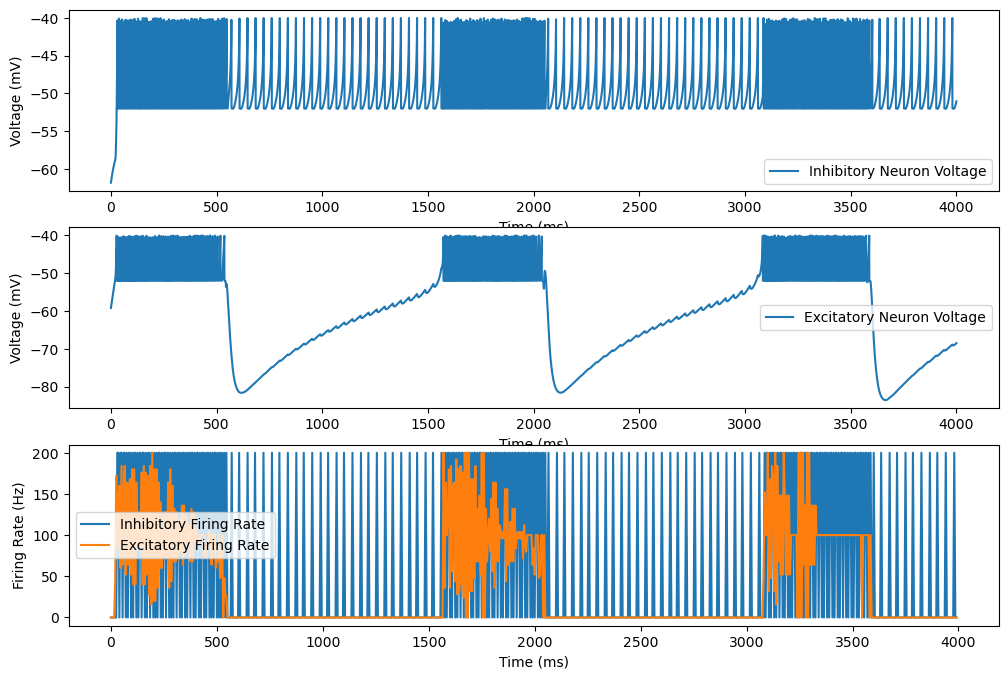

--## Start simulation for Nb1=10 and Nb2=2 ##--
--## End simulation ##--


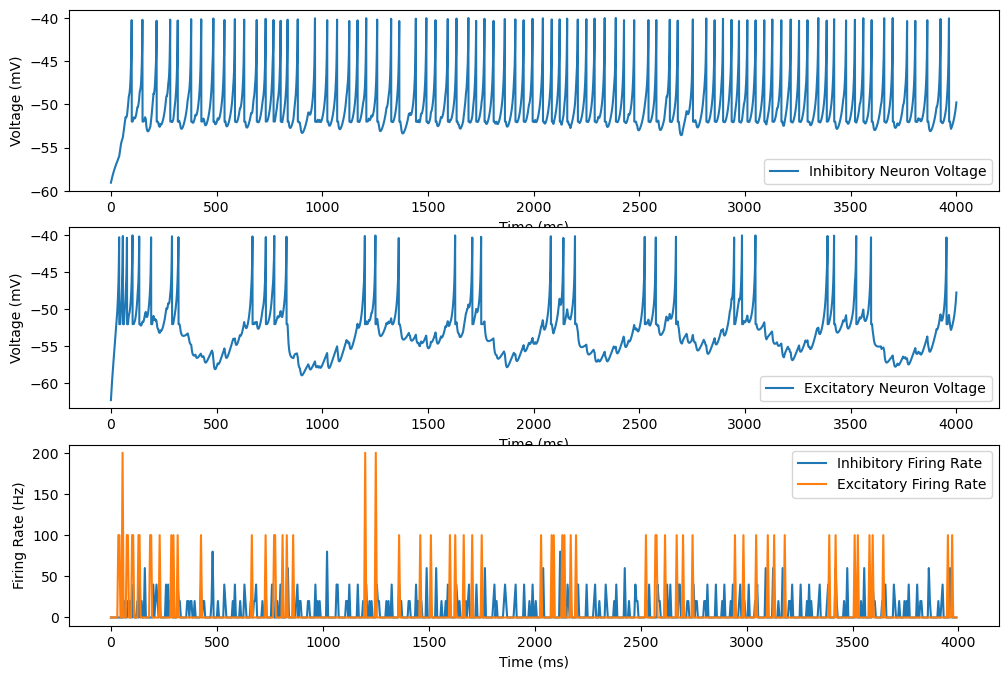

--## Start simulation for Nb1=10 and Nb2=10 ##--
--## End simulation ##--


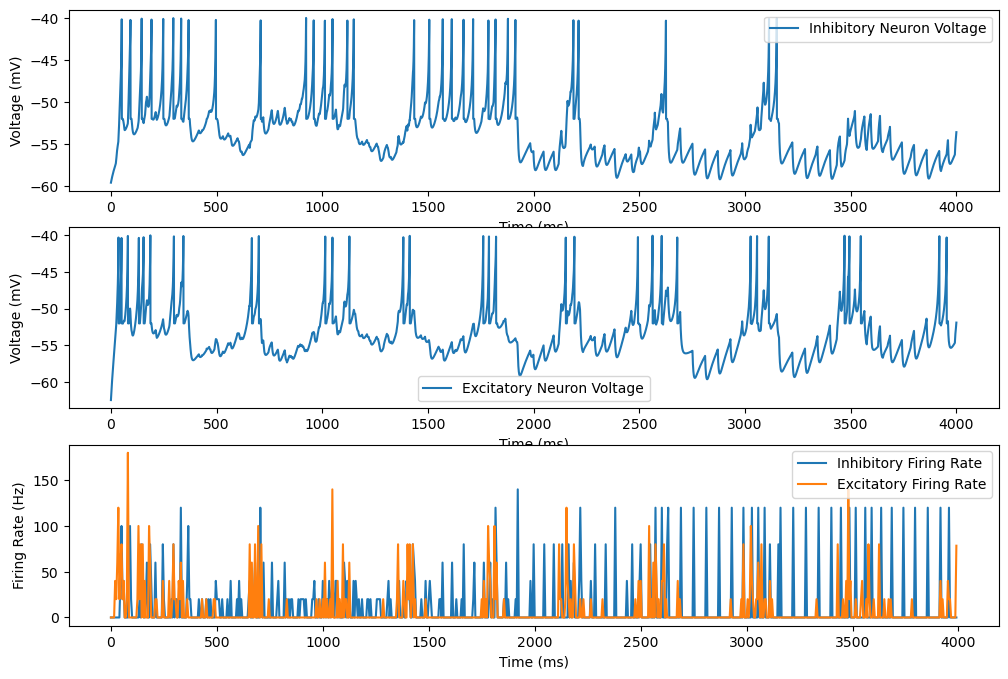

--## Start simulation for Nb1=10 and Nb2=50 ##--
--## End simulation ##--


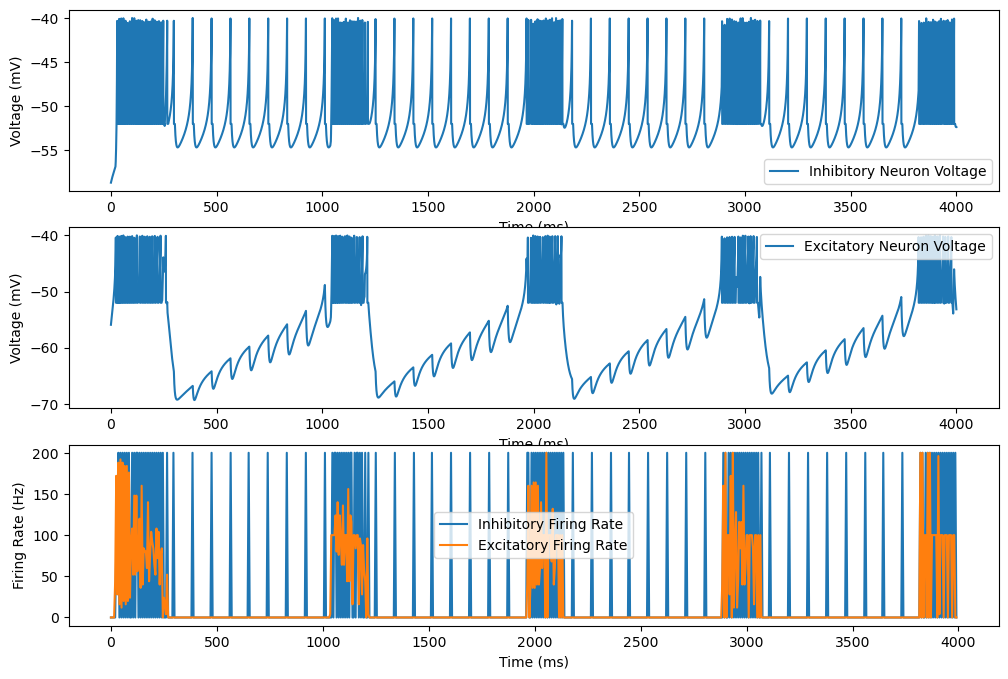

--## Start simulation for Nb1=50 and Nb2=2 ##--
--## End simulation ##--


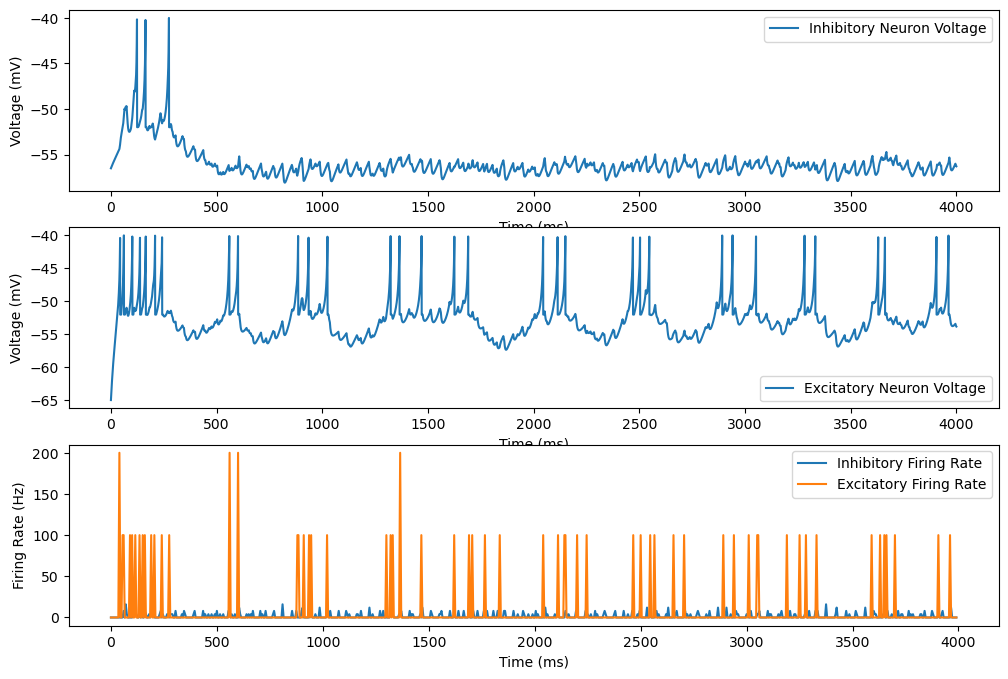

--## Start simulation for Nb1=50 and Nb2=10 ##--
--## End simulation ##--


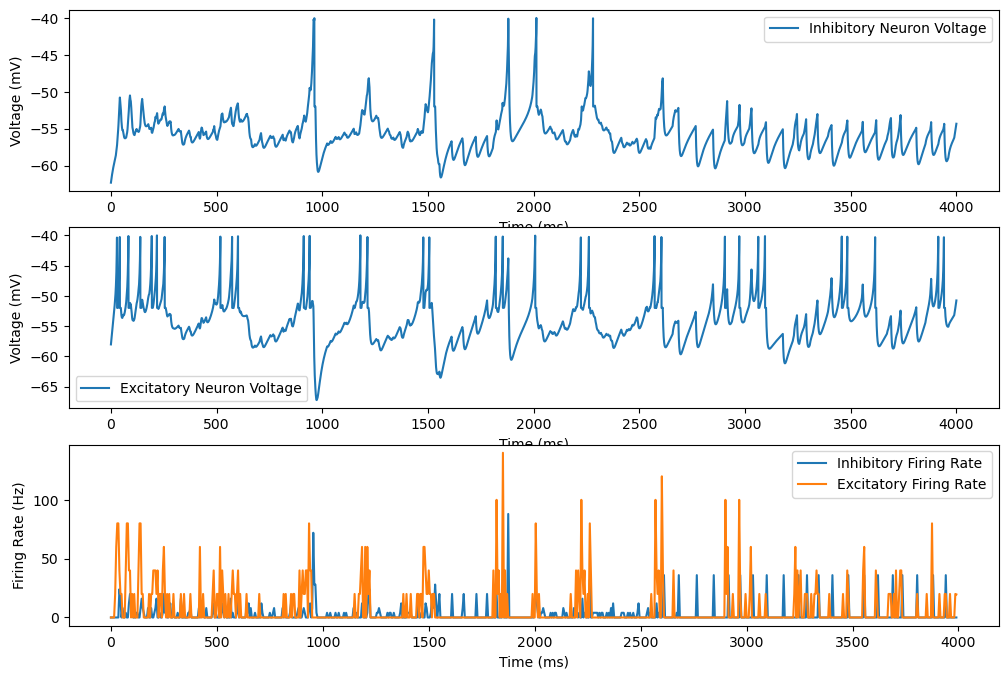

--## Start simulation for Nb1=50 and Nb2=50 ##--
--## End simulation ##--


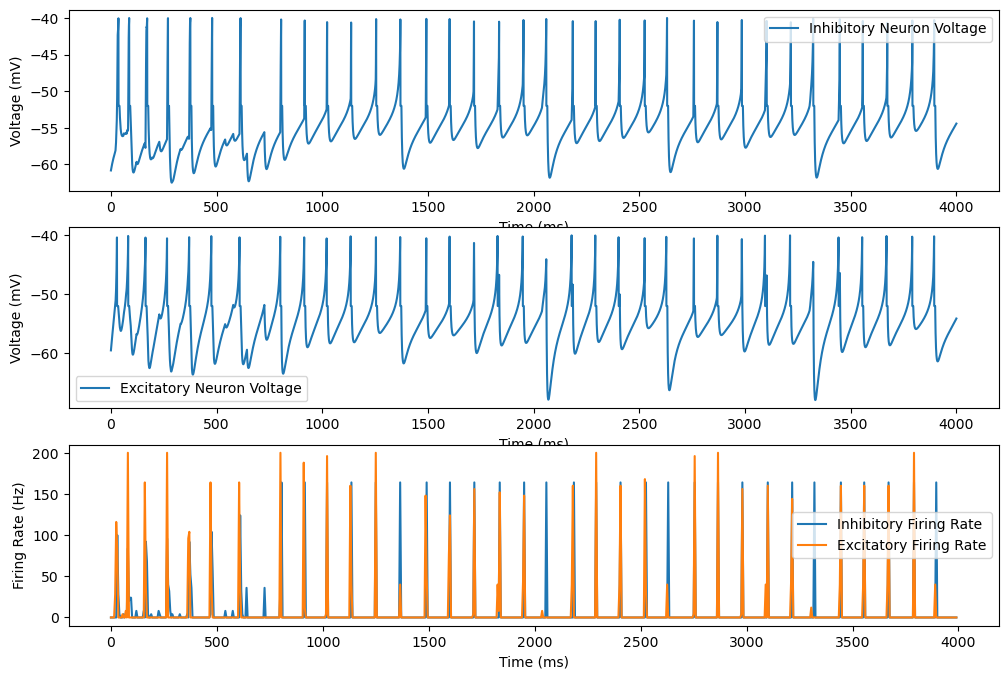

In [35]:
from brian2 import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

%matplotlib inline

#########################
# Simulation conditions #-------------------------------------------------------------------------
#########################

DT = 0.1  # time step
defaultclock.dt = DT * ms
TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

###############
# Equations ###----------------------------------------------------------------------------------
###############
eqs = '''
# Neuron dynamics:
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
# Model of synapses:
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
# Parameters:
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

##################
# Define a function to initialize and run the simulation for each combination of neurons #
##################
def bin_array(data, bin_size, time_array):
    bins = np.arange(time_array[0], time_array[-1], bin_size)
    binned_data = binned_statistic(time_array, data, statistic='mean', bins=bins)[0]
    return bins[:-1], binned_data

def run_simulation(Nb1, Nb2):
    # Define neuron groups
    if Nb1 != 0:
        # Inhibitory neurons
        G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
        for k in range(len(G_inh.v)):
            G_inh.v[k] = random.uniform(-55, -65) * mV

        G_inh.w = 0.0 * pA
        G_inh.GsynI = 0.0 * nS
        G_inh.GsynE = 0.0 * nS
        # Parameter values for inhibitory neurons
        b1 = 0.0 * pA
        G_inh.Cm = 200.0 * pF
        G_inh.gl = 10.0 * nS
        G_inh.El = -65.0 * mV
        G_inh.Vt = -55.0 * mV
        G_inh.Dt = 5.0 * mV
        G_inh.tau_w = 500.0 * ms
        G_inh.a = 0.0 * nS
        G_inh.Is = .06 * nA
        G_inh.Ee = 0.0 * mV
        G_inh.Ei = -80.0 * mV
        G_inh.Tsyn = 5.0 * ms

    if Nb2 != 0:
        # Excitatory neurons
        G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
        for k in range(len(G_exc.v)):
            G_exc.v[k] = random.uniform(-55, -65) * mV

        G_exc.w = 0.0 * pA
        G_exc.GsynI = 0.0 * nS
        G_exc.GsynE = 0.0 * nS
        # Parameter values for excitatory neurons
        b2 = 10.0 * pA
        G_exc.Cm = 200.0 * pF
        G_exc.gl = 10.0 * nS
        G_exc.El = -65.0 * mV
        G_exc.Vt = -55.0 * mV
        G_exc.Dt = 5.0 * mV
        G_exc.tau_w = 500.0 * ms
        G_exc.a = 2.0 * nS
        G_exc.Is = .120 * nA
        G_exc.Ee = 0.0 * mV
        G_exc.Ei = -80.0 * mV
        G_exc.Tsyn = 5.0 * ms

    ##################
    # Synapses setup #
    ##################
    Qi = 1.5 * nS
    Qe = 0.5 * nS

    if Nb1 != 0:
        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
        S_11.connect(p=1)

    if Nb2 != 0:
        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
        S_22.connect(p=1)

    if Nb1 != 0 and Nb2 != 0:
        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
        S_21.connect(p=1)
        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
        S_12.connect(p=1)

    ##################
    # Recording tools #
    ##################
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

    ##################
    # Run simulation #
    ##################
    print(f'--## Start simulation for Nb1={Nb1} and Nb2={Nb2} ##--')
    run(duration)
    print('--## End simulation ##--')

    ##################
    # Data processing #
    ##################
    BIN = 5
    time_array = arange(int(TotTime / DT)) * DT

    LVG1 = [array(M2G1[a].v / mV) for a in range(Nb1)]
    LwG1 = [array(M3G1[a].w / mamp) for a in range(Nb1)]
    LVG2 = [array(M2G2[a].v / mV) for a in range(Nb2)]
    LwG2 = [array(M3G2[a].w / mamp) for a in range(Nb2)]

    LfrG1 = np.array(FRG1.rate / Hz)
    TimBinned, popRateG_inh = bin_array(LfrG1, BIN, time_array)
    LfrG2 = np.array(FRG2.rate / Hz)
    TimBinned, popRateG_exc = bin_array(LfrG2, BIN, time_array)

    ##################
    # Visualization #
    ##################
    # Voltage plots
    plt.figure(figsize=(12, 8))
    plt.subplot(311)
    plt.plot(time_array, LVG1[0], label="Inhibitory Neuron Voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()

    plt.subplot(312)
    plt.plot(time_array, LVG2[0], label="Excitatory Neuron Voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()

    # Firing Rate plot
    plt.subplot(313)
    plt.plot(TimBinned, popRateG_inh, label="Inhibitory Firing Rate")
    plt.plot(TimBinned, popRateG_exc, label="Excitatory Firing Rate")
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.show()

##################
# Experiment with different number of neurons
##################
Nb1_values = [2, 10, 50]
Nb2_values = [2, 10, 50]

for Nb1 in Nb1_values:
    for Nb2 in Nb2_values:
        run_simulation(Nb1, Nb2)


--## Start simulation for Nb1=2 and Nb2=2 ##--
--## End simulation ##--


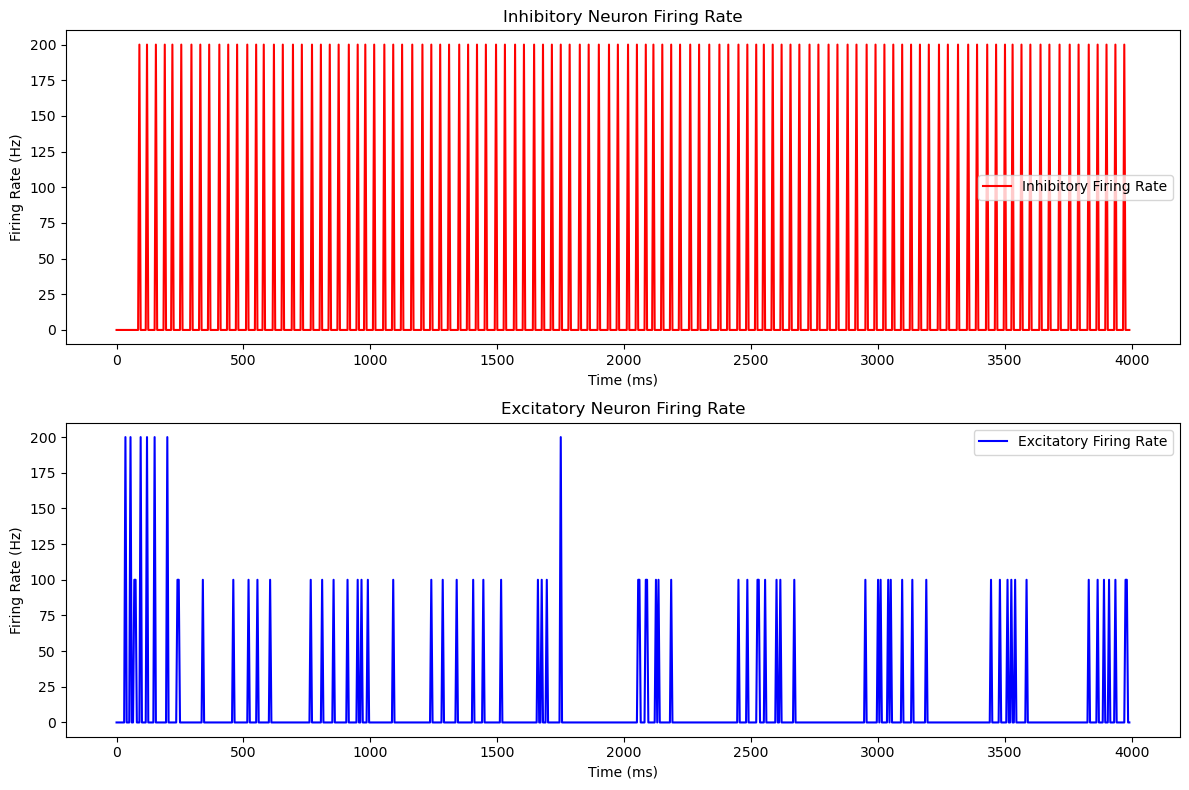

--## Start simulation for Nb1=2 and Nb2=10 ##--
--## End simulation ##--


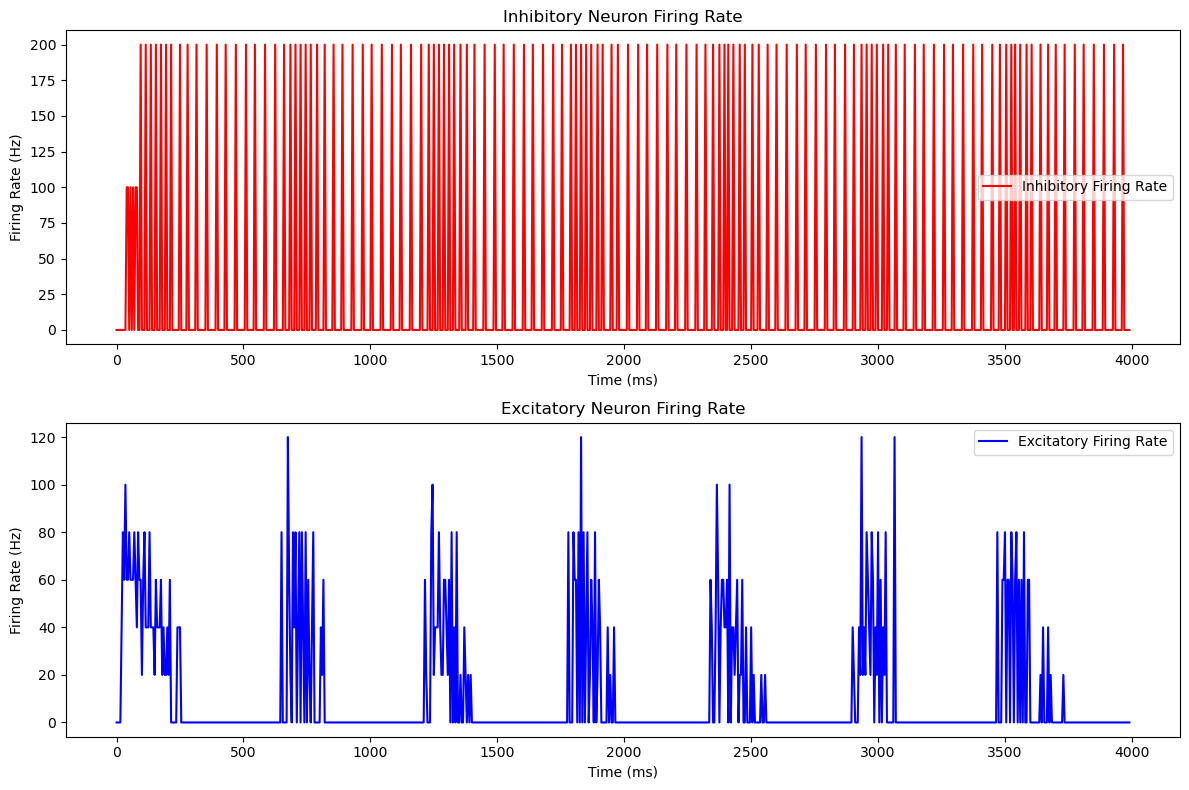

--## Start simulation for Nb1=2 and Nb2=50 ##--
--## End simulation ##--


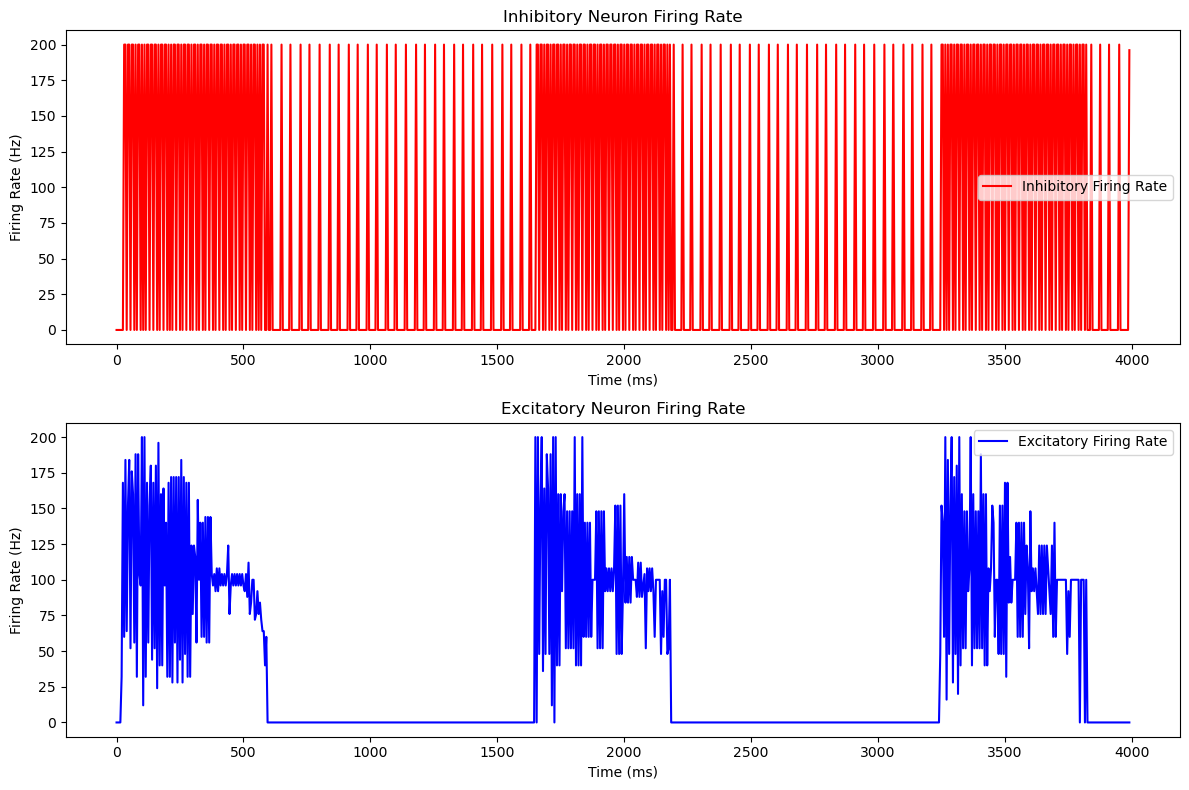

--## Start simulation for Nb1=10 and Nb2=2 ##--
--## End simulation ##--


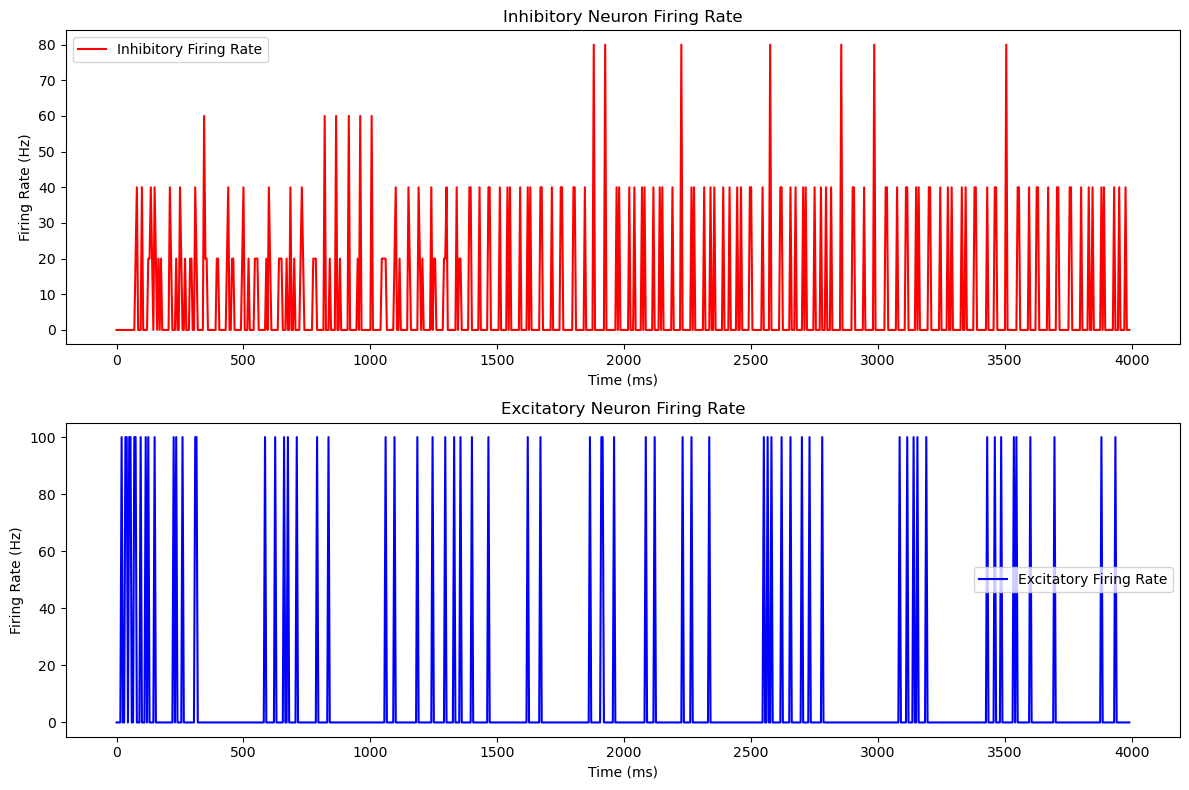

--## Start simulation for Nb1=10 and Nb2=10 ##--
--## End simulation ##--


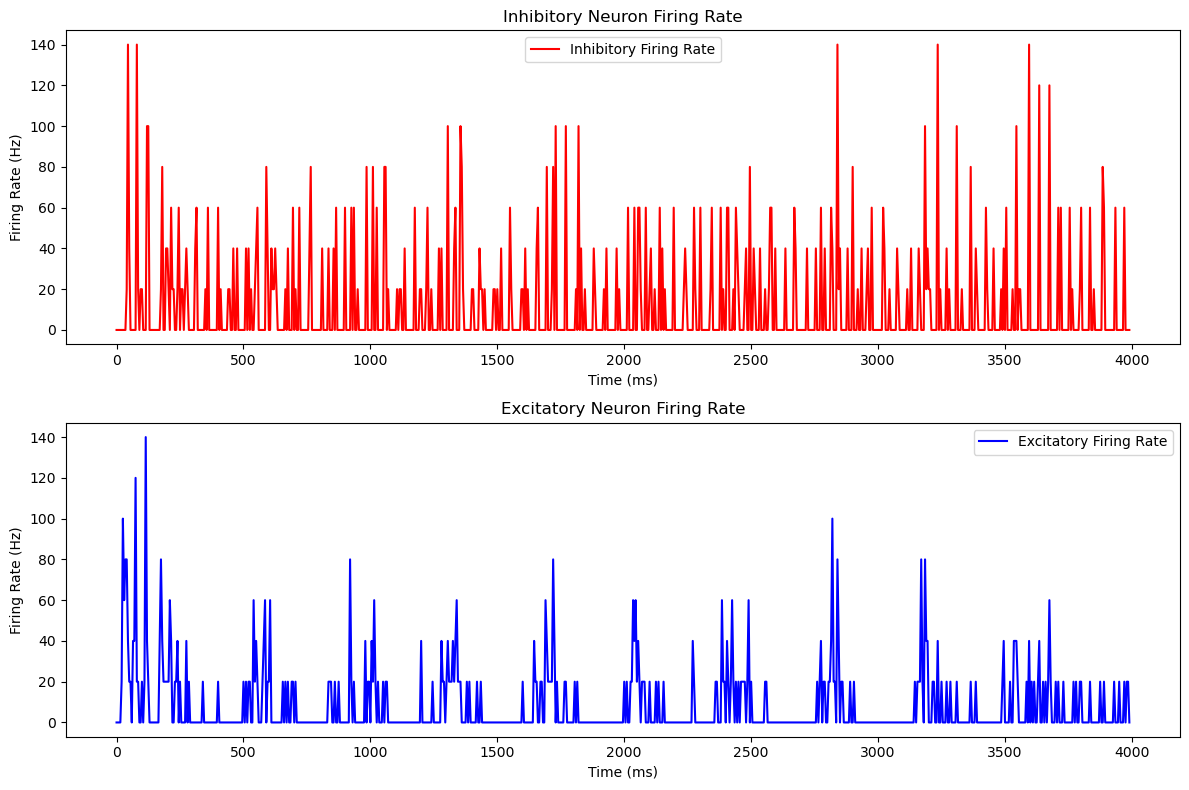

--## Start simulation for Nb1=10 and Nb2=50 ##--
--## End simulation ##--


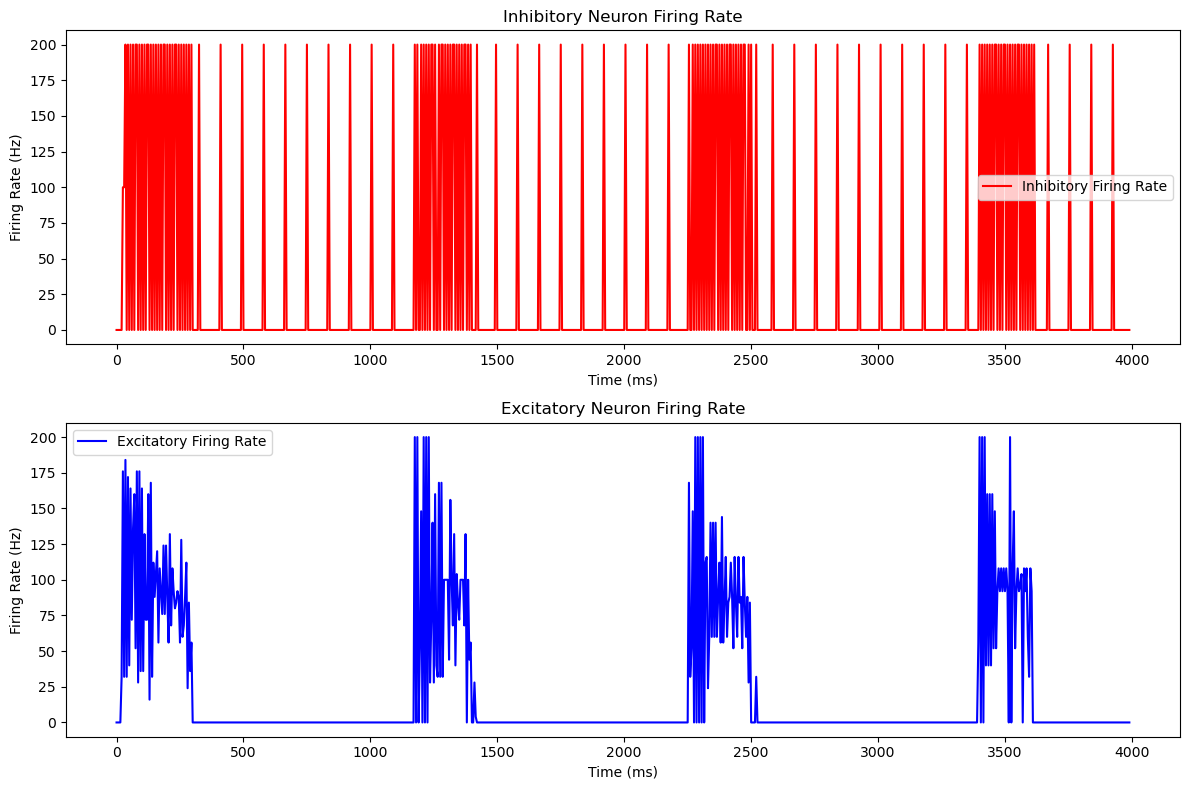

--## Start simulation for Nb1=50 and Nb2=2 ##--
--## End simulation ##--


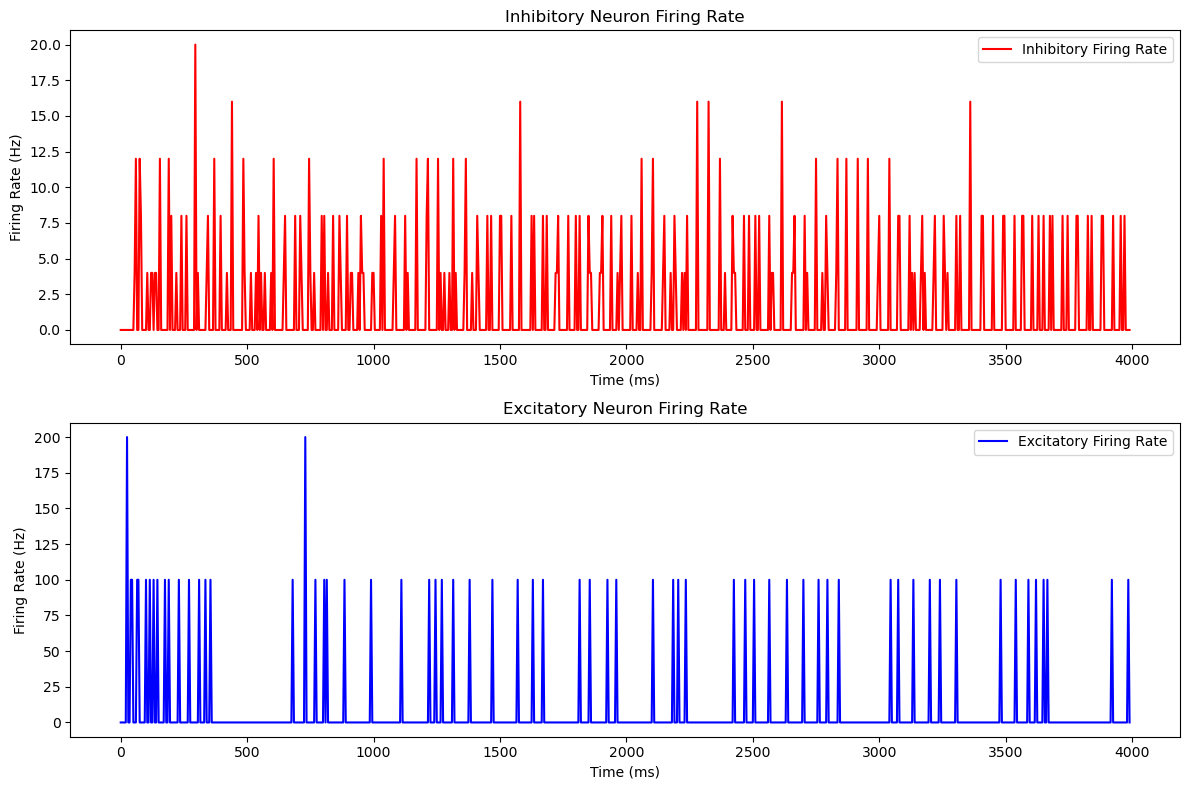

--## Start simulation for Nb1=50 and Nb2=10 ##--
--## End simulation ##--


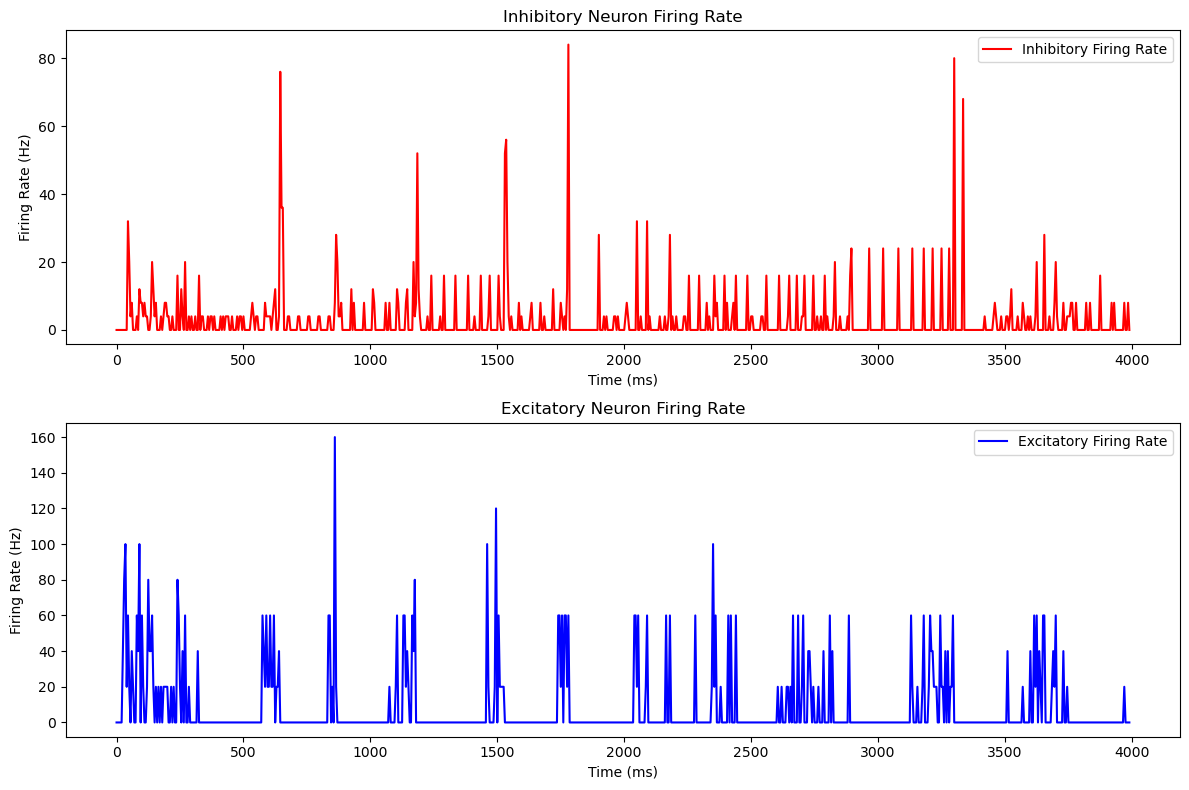

--## Start simulation for Nb1=50 and Nb2=50 ##--
--## End simulation ##--


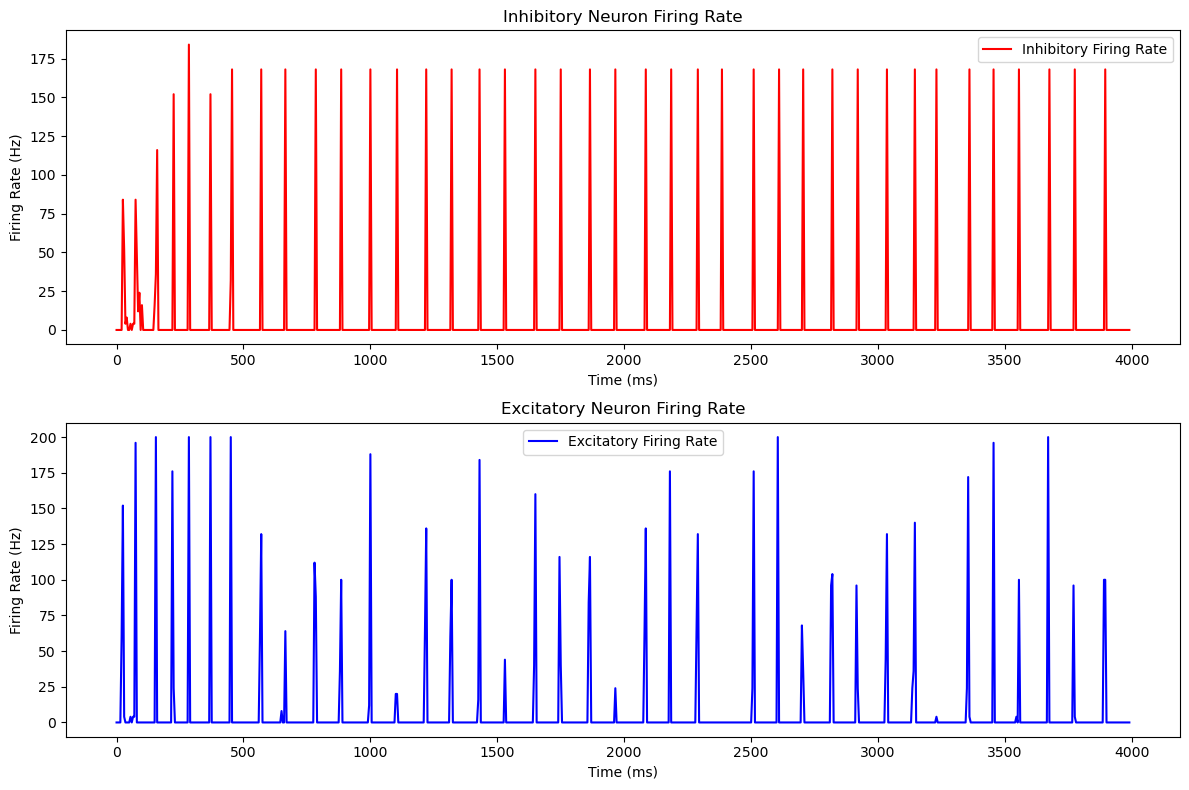

In [39]:
from brian2 import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

%matplotlib inline

#########################
# Simulation conditions #
#########################
DT = 0.1  # time step
defaultclock.dt = DT * ms
TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

###############
# Equations ###
###############
eqs = '''
# Neuron dynamics:
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
# Model of synapses:
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
# Parameters:
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

##################
# Define a function to initialize and run the simulation for each combination of neurons #
##################
def bin_array(data, bin_size, time_array):
    bins = np.arange(time_array[0], time_array[-1], bin_size)
    binned_data = binned_statistic(time_array, data, statistic='mean', bins=bins)[0]
    return bins[:-1], binned_data

def run_simulation(Nb1, Nb2, Qi_variability=0.1, Qe_variability=0.1):
    # Define neuron groups
    if Nb1 != 0:
        # Inhibitory neurons
        G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
        for k in range(len(G_inh.v)):
            G_inh.v[k] = random.uniform(-55, -65) * mV

        G_inh.w = 0.0 * pA
        G_inh.GsynI = 0.0 * nS
        G_inh.GsynE = 0.0 * nS
        # Parameter values for inhibitory neurons
        b1 = 0.0 * pA
        G_inh.Cm = 200.0 * pF
        G_inh.gl = 10.0 * nS
        G_inh.El = -65.0 * mV
        G_inh.Vt = -55.0 * mV
        G_inh.Dt = 5.0 * mV
        G_inh.tau_w = 500.0 * ms
        G_inh.a = 0.0 * nS
        G_inh.Is = .06 * nA
        G_inh.Ee = 0.0 * mV
        G_inh.Ei = -80.0 * mV
        G_inh.Tsyn = 5.0 * ms

    if Nb2 != 0:
        # Excitatory neurons
        G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
        for k in range(len(G_exc.v)):
            G_exc.v[k] = random.uniform(-55, -65) * mV

        G_exc.w = 0.0 * pA
        G_exc.GsynI = 0.0 * nS
        G_exc.GsynE = 0.0 * nS
        # Parameter values for excitatory neurons
        b2 = 10.0 * pA
        G_exc.Cm = 200.0 * pF
        G_exc.gl = 10.0 * nS
        G_exc.El = -65.0 * mV
        G_exc.Vt = -55.0 * mV
        G_exc.Dt = 5.0 * mV
        G_exc.tau_w = 500.0 * ms
        G_exc.a = 2.0 * nS
        G_exc.Is = .120 * nA
        G_exc.Ee = 0.0 * mV
        G_exc.Ei = -80.0 * mV
        G_exc.Tsyn = 5.0 * ms

    ##################
    # Synapses setup #
    ##################
    Qi = 1.5 * nS + random.uniform(-Qi_variability, Qi_variability) * nS
    Qe = 0.5 * nS + random.uniform(-Qe_variability, Qe_variability) * nS

    if Nb1 != 0:
        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
        S_11.connect(p=1)

    if Nb2 != 0:
        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
        S_22.connect(p=1)

    if Nb1 != 0 and Nb2 != 0:
        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
        S_21.connect(p=1)
        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
        S_12.connect(p=1)

    ##################
    # Recording tools #
    ##################
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

    ##################
    # Run simulation #
    ##################
    print(f'--## Start simulation for Nb1={Nb1} and Nb2={Nb2} ##--')
    run(duration)
    print('--## End simulation ##--')

    ##################
    # Data processing #
    ##################
    BIN = 5
    time_array = arange(int(TotTime / DT)) * DT

    LVG1 = [array(M2G1[a].v / mV) for a in range(Nb1)]
    LwG1 = [array(M3G1[a].w / mamp) for a in range(Nb1)]
    LVG2 = [array(M2G2[a].v / mV) for a in range(Nb2)]
    LwG2 = [array(M3G2[a].w / mamp) for a in range(Nb2)]

    LfrG1 = np.array(FRG1.rate / Hz)
    TimBinned, popRateG_inh = bin_array(LfrG1, BIN, time_array)
    LfrG2 = np.array(FRG2.rate / Hz)
    TimBinned, popRateG_exc = bin_array(LfrG2, BIN, time_array)

    ##################
    # Visualization #
    ##################
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(TimBinned, popRateG_inh, label="Inhibitory Firing Rate", color='red')
    plt.title('Inhibitory Neuron Firing Rate')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()

    plt.subplot(212)
    plt.plot(TimBinned, popRateG_exc, label="Excitatory Firing Rate", color='blue')
    plt.title('Excitatory Neuron Firing Rate')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()

    plt.tight_layout()
    plt.show()

##################
# Experiment with different numbers of neurons
##################
Nb1_values = [2, 10, 50]
Nb2_values = [2, 10, 50]

for Nb1 in Nb1_values:
    for Nb2 in Nb2_values:
        run_simulation(Nb1, Nb2, Qi_variability=0.1, Qe_variability=0.1)


2. **Are there levels of input (or interaction) for which such description is relevant to understand the global dynamics?**

   Yes, the phase portrait of a single neuron is still useful when considering the global dynamics of a network, especially when the level of input or synaptic interaction between neurons is small. For example:
   - **Low interaction**: If the coupling strength between neurons (e.g., \( Q_e \) and \( Q_i \)) is small, the neurons might still behave almost independently, and the global dynamics might be approximated by the sum of the individual dynamics. In this case, the phase portrait of a single neuron can provide insight into the firing behavior of the entire network.
   - **Intermediate interaction**: If the interaction strength increases, the network might start exhibiting synchronous firing or oscillations. The system may still be interpretable by considering the individual dynamics of the neurons, but you also need to account for the interactions (e.g., via coupling terms in the equations) and how they modulate the individual dynamics.
   - **High interaction**: At very high levels of coupling, the individual neurons' behavior may no longer be the dominant factor, and the network might exhibit complex collective phenomena, like synchronized bursts or chaos. At this point, the phase portrait of a single neuron becomes less informative for understanding global dynamics.

   So, for **low-to-moderate** coupling, the phase portrait of a single neuron is still relevant. However, as the interactions increase, you need to consider network-wide dynamics, including feedback loops, oscillations, and collective behavior.

3. **How to characterize the behavior of the global system?**

   To characterize the global behavior of the coupled system, you need to consider:
   - **Population dynamics**: Population rate monitors or average firing rates can give insight into whether the network is oscillating or firing synchronously. This would help determine if the network is in a periodic or chaotic state.
   - **Phase synchronization**: Analyzing the phase relationship between the neurons or neuron groups can reveal whether the network exhibits synchronized oscillations.
   - **Mean-field analysis**: In some cases, simplifying the network by considering the average behavior of the neurons (e.g., a mean-field approximation) can help characterize the global dynamics.
   - **Spectral analysis**: Using tools like power spectral density to look at the frequency content of the network’s output can give information about the global behavior, such as whether the network exhibits periodic oscillations or chaotic behavior.
   - **Attractor analysis**: Exploring whether the system tends to certain attractors (such as limit cycles or chaotic attractors) in the high-dimensional phase space of the network can also help characterize the global system behavior.

4. **What if we increase the number of neudels in the network?**

   Increasing the number of neurons (or neudels) in the network leads to the following:
   - **Synchronization**: With more neurons, it’s possible that the network may exhibit collective behavior such as synchronization, where the neurons fire in unison or in specific patterns. This is particularly true for excitatory neurons in large networks.
   - **Network effects**: As the number of neurons increases, the influence of individual neurons may become less significant compared to the collective behavior of the population. For instance, certain emergent properties like oscillations or chaotic behavior may arise that are not present in small networks.
   - **Phase transitions**: A larger network might undergo phase transitions depending on the connectivity and interaction strengths. For example, as the coupling strength increases, the network might transition from random firing to synchronized oscillations or even to chaotic states.
   - **Noise and robustness**: Larger networks may be more robust to noise, as the collective behavior of many neurons can average out individual fluctuations. However, large networks may also exhibit more complex and harder-to-predict dynamics, especially when the synaptic weights or external inputs are varied.

   In summary, increasing the number of neurons introduces more complex dynamics and interactions that are harder to predict from the individual phase portraits. Instead, network-wide tools and analyses, like population firing rates and synchronization measures, become more relevant.


--## Start simulation for Nb1=2 and Nb2=2 ##--


WARNING    'Cm' is an internal variable of group 'neurongroup_14', but also exists in the run namespace with the value 200. * pfarad. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Dt' is an internal variable of group 'neurongroup_14', but also exists in the run namespace with the value 5. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ee' is an internal variable of group 'neurongroup_14', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ei' is an internal variable of group 'neurongroup_14', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'El' is an internal variable of group 'neurongroup_14', but also exists in the run namespace 

--## End simulation ##--


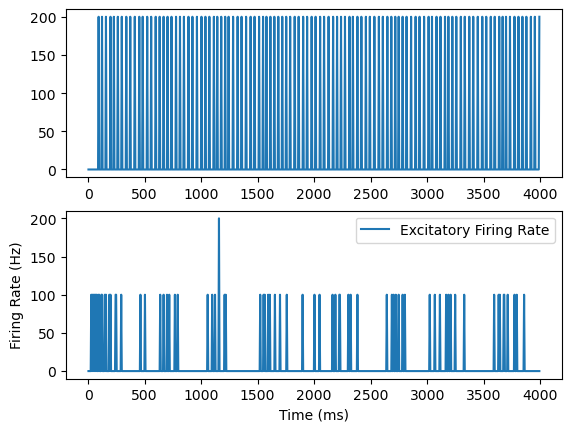

--## Start simulation for Nb1=2 and Nb2=10 ##--
--## End simulation ##--


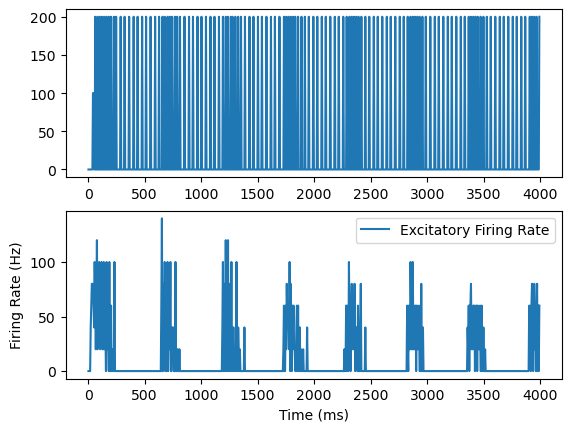

--## Start simulation for Nb1=2 and Nb2=50 ##--
--## End simulation ##--


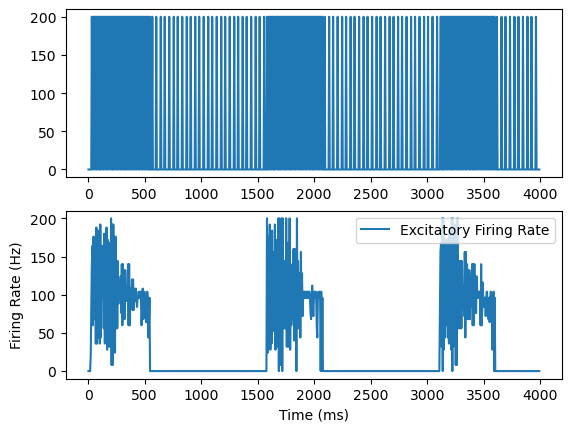

--## Start simulation for Nb1=10 and Nb2=2 ##--
--## End simulation ##--


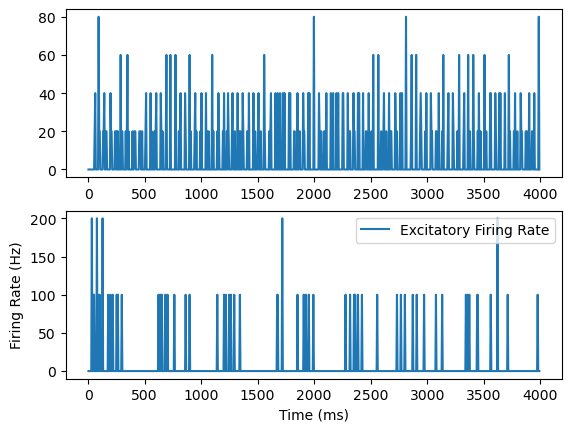

--## Start simulation for Nb1=10 and Nb2=10 ##--
--## End simulation ##--


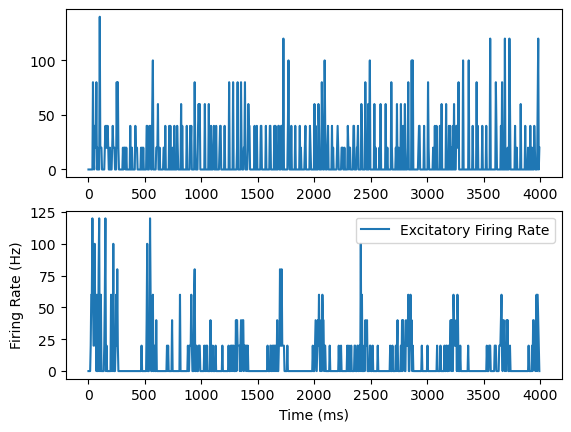

--## Start simulation for Nb1=10 and Nb2=50 ##--
--## End simulation ##--


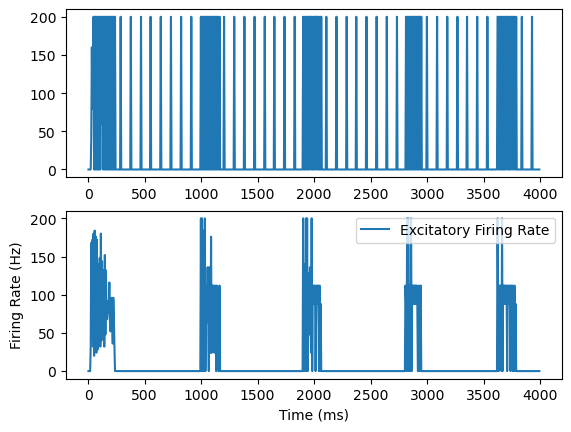

--## Start simulation for Nb1=50 and Nb2=2 ##--
--## End simulation ##--


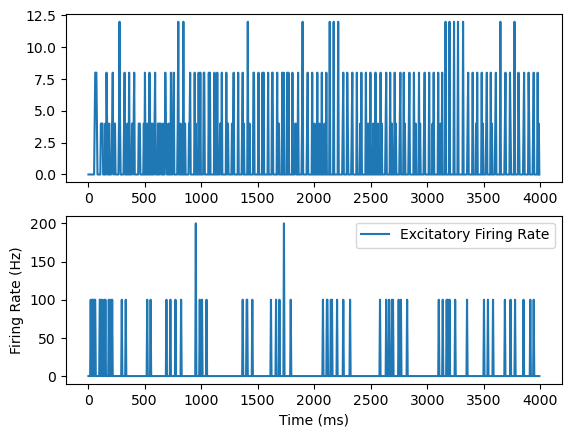

--## Start simulation for Nb1=50 and Nb2=10 ##--
--## End simulation ##--


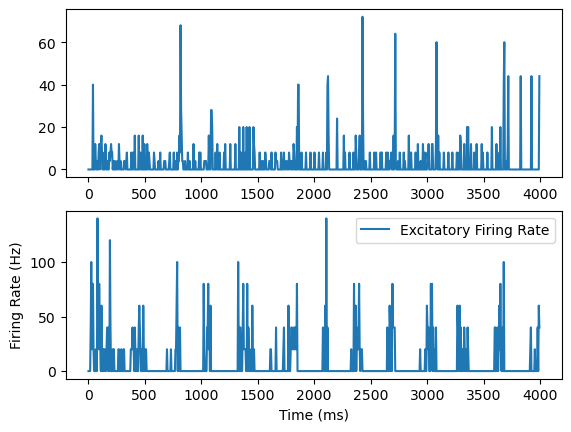

--## Start simulation for Nb1=50 and Nb2=50 ##--
--## End simulation ##--


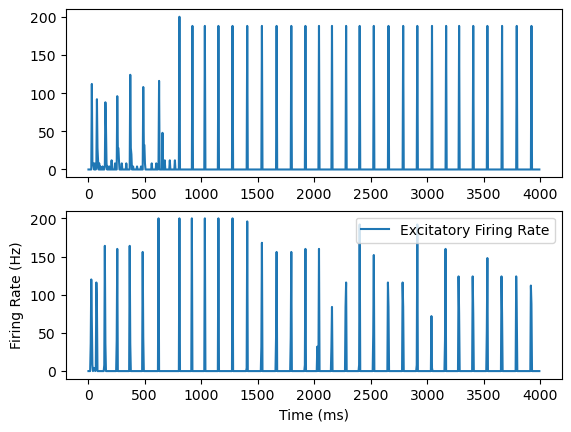

In [26]:
from brian2 import *
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#########################
# Simulation conditions #-------------------------------------------------------------------------
#########################


DT = 0.1  # time step
defaultclock.dt = DT * ms
TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

###############
# Equations ###----------------------------------------------------------------------------------
###############
eqs = '''
# Neuron dynamics:
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
# Model of synapses:
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
# Parameters:
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

##################
# Define a function to initialize and run the simulation for each combination of neurons #
##################
def run_simulation(Nb1, Nb2):
    # Define neuron groups
    if Nb1 != 0:
        # Inhibitory neurons
        G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
        for k in range(len(G_inh.v)):
            G_inh.v[k] = random.uniform(-55, -65) * mV

        G_inh.w = 0.0 * pA
        G_inh.GsynI = 0.0 * nS
        G_inh.GsynE = 0.0 * nS
        # Parameter values for inhibitory neurons
        b1 = 0.0 * pA
        G_inh.Cm = 200.0 * pF
        G_inh.gl = 10.0 * nS
        G_inh.El = -65.0 * mV
        G_inh.Vt = -55.0 * mV
        G_inh.Dt = 5.0 * mV
        G_inh.tau_w = 500.0 * ms
        G_inh.a = 0.0 * nS
        G_inh.Is = .06 * nA
        G_inh.Ee = 0.0 * mV
        G_inh.Ei = -80.0 * mV
        G_inh.Tsyn = 5.0 * ms

    if Nb2 != 0:
        # Excitatory neurons
        G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
        for k in range(len(G_exc.v)):
            G_exc.v[k] = random.uniform(-55, -65) * mV

        G_exc.w = 0.0 * pA
        G_exc.GsynI = 0.0 * nS
        G_exc.GsynE = 0.0 * nS
        # Parameter values for excitatory neurons
        b2 = 10.0 * pA
        G_exc.Cm = 200.0 * pF
        G_exc.gl = 10.0 * nS
        G_exc.El = -65.0 * mV
        G_exc.Vt = -55.0 * mV
        G_exc.Dt = 5.0 * mV
        G_exc.tau_w = 500.0 * ms
        G_exc.a = 2.0 * nS
        G_exc.Is = .120 * nA
        G_exc.Ee = 0.0 * mV
        G_exc.Ei = -80.0 * mV
        G_exc.Tsyn = 5.0 * ms

    ##################
    # Synapses setup #
    ##################
    Qi = 1.5 * nS
    Qe = 0.5 * nS

    if Nb1 != 0:
        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
        S_11.connect(p=1)

    if Nb2 != 0:
        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
        S_22.connect(p=1)

    if Nb1 != 0 and Nb2 != 0:
        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
        S_21.connect(p=1)
        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
        S_12.connect(p=1)

    ##################
    # Recording tools #
    ##################
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

    ##################
    # Run simulation #
    ##################
    print(f'--## Start simulation for Nb1={Nb1} and Nb2={Nb2} ##--')
    run(duration)
    print('--## End simulation ##--')

    ##################
    # Data processing #
    ##################
    BIN = 5
    time_array = arange(int(TotTime / DT)) * DT

    LVG1 = [array(M2G1[a].v / mV) for a in range(Nb1)]
    LwG1 = [array(M3G1[a].w / mamp) for a in range(Nb1)]
    LVG2 = [array(M2G2[a].v / mV) for a in range(Nb2)]
    LwG2 = [array(M3G2[a].w / mamp) for a in range(Nb2)]

    LfrG1 = np.array(FRG1.rate / Hz)
    TimBinned, popRateG_inh = bin_array(time_array, BIN, time_array), bin_array(LfrG1, BIN, time_array)
    LfrG2 = np.array(FRG2.rate / Hz)
    TimBinned, popRateG_exc = bin_array(time_array, BIN, time_array), bin_array(LfrG2, BIN, time_array)

    ##################
    # Visualization #
    ##################
    plt.figure()
    plt.subplot(211)
    plt.plot(TimBinned, popRateG_inh, label="Inhibitory Firing Rate")
    plt.subplot(212)
    plt.plot(TimBinned, popRateG_exc, label="Excitatory Firing Rate")
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.show()

##################
# Experiment with different number of neurons
##################
Nb1_values = [2, 10, 50]
Nb2_values = [2, 10, 50]

for Nb1 in Nb1_values:
    for Nb2 in Nb2_values:
        run_simulation(Nb1, Nb2)


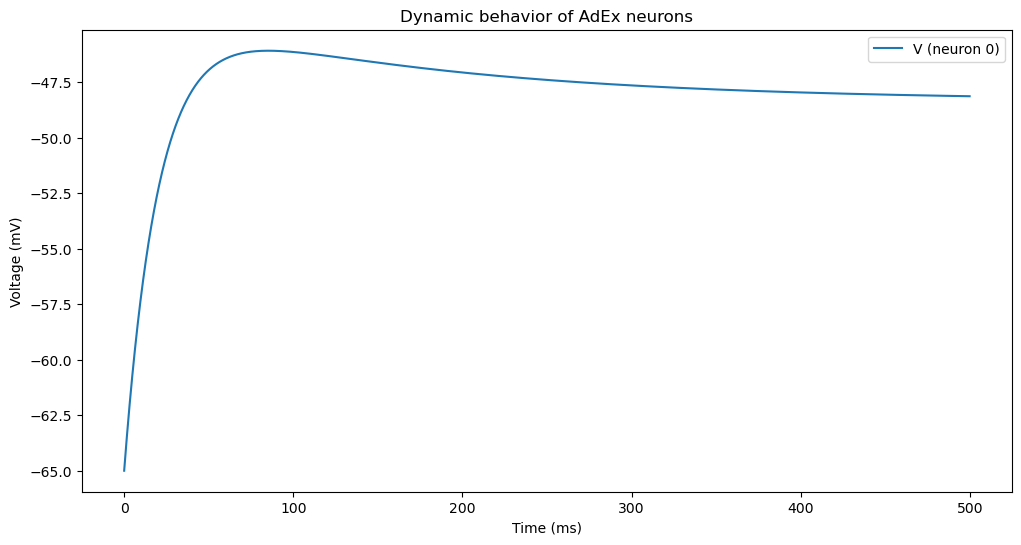

In [10]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Initialisation
start_scope()

# Paramètres globaux
duration = 500 * ms
N_exc = 10  # Nombre de neurones excitateurs
N_inh = 10  # Nombre de neurones inhibiteurs

# Paramètres réseau
Ee = 0 * mV
Ei = -80 * mV
tau_synE = 5 * ms
tau_synI = 10 * ms

# Équations neuronales
eqs = '''
dv/dt = (gl * (El - v) + Isyn + Iext - w) / Cm : volt
dw/dt = (a * (v - El) - w) / tau_w : amp
Isyn = gE * (Ee - v) + gI * (Ei - v) : amp
dgE/dt = -gE / tau_synE : siemens
dgI/dt = -gI / tau_synI : siemens
Iext : amp
'''

# Paramètres neuronaux
Cm = 200 * pF
gl = 10 * nS
El = -65 * mV
a = 2 * nS
tau_w = 200 * ms

# Groupes neuronaux
G_exc = NeuronGroup(
    N_exc, eqs,
    threshold='v > -40 * mV',
    reset='v = -52 * mV; w += 10 * pA',
    refractory=5 * ms,
    method='euler'
)
G_exc.v = El
G_exc.w = 0 * pA
G_exc.Iext = 200 * pA  # Exemple de courant externe

G_inh = NeuronGroup(
    N_inh, eqs,
    threshold='v > -40 * mV',
    reset='v = -52 * mV; w += 10 * pA',
    refractory=5 * ms,
    method='euler'
)
G_inh.v = El
G_inh.w = 0 * pA
G_inh.Iext = 200 * pA  # Exemple de courant externe

# Synapses
S_ee = Synapses(G_exc, G_exc, on_pre='gE += 0.1 * nS')
S_ei = Synapses(G_exc, G_inh, on_pre='gE += 0.1 * nS')
S_ie = Synapses(G_inh, G_exc, on_pre='gI += 0.1 * nS')
S_ii = Synapses(G_inh, G_inh, on_pre='gI += 0.1 * nS')

S_ee.connect(p=0.1)
S_ei.connect(p=0.1)
S_ie.connect(p=0.1)
S_ii.connect(p=0.1)

# Moniteurs
mon_exc = StateMonitor(G_exc, ['v', 'w'], record=True)
spike_exc = SpikeMonitor(G_exc)
spike_inh = SpikeMonitor(G_inh)

# Création et simulation du réseau
net = Network(G_exc, G_inh, S_ee, S_ei, S_ie, S_ii, mon_exc, spike_exc, spike_inh)
net.run(duration)

# Tracé des résultats
plt.figure(figsize=(12, 6))
plt.plot(mon_exc.t / ms, mon_exc.v[0] / mV, label='V (neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Dynamic behavior of AdEx neurons')
plt.legend()
plt.show()


WARNING    'Cm' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 200. * pfarad. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ee' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ei' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'El' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value -65. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with

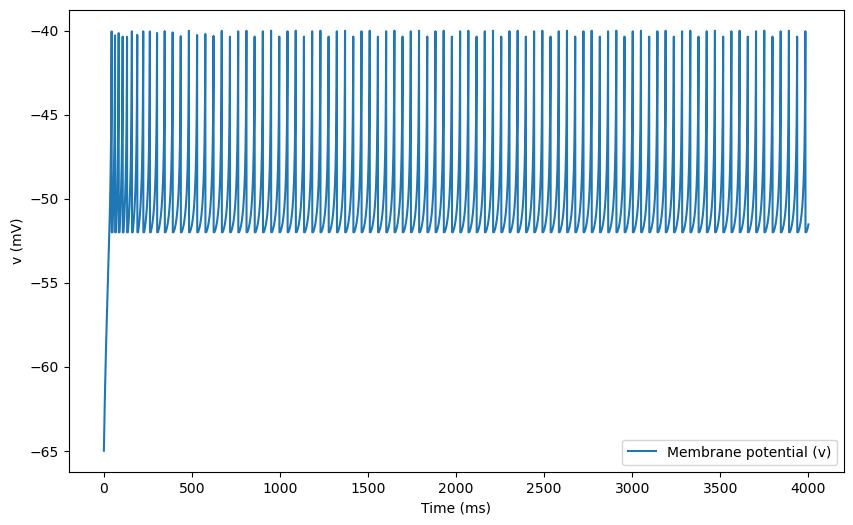

In [13]:
from brian2 import *

# Simulation parameters
start_scope()
DT = 0.1  # Time step
defaultclock.dt = DT * ms
duration = 4000 * ms  # Total duration

# Define neuron model equations
eqs = '''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is: ampere
Ig: ampere
Cm: farad
gl: siemens
El: volt
a: siemens
tau_w: second
Dt: volt
Vt: volt
Ee: volt
Ei: volt
Tsyn: second
'''

# Create a single neuron population
G = NeuronGroup(1, eqs, threshold='v > -40*mV', reset='v = -52*mV; w += 10*pA', refractory=5*ms, method='euler')
G.v = -65 * mV
G.w = 0.0 * pA
G.GsynE = 0.0 * nS
G.GsynI = 0.0 * nS

# Define parameters directly for the neuron group
G.Cm = 200. * pF
G.gl = 10. * nS
G.El = -65. * mV
G.Vt = -55. * mV
G.Dt = 5. * mV
G.tau_w = 200. * ms
G.a = 2. * nS
G.Is = 0.120 * nA
G.Ee = 0. * mV
G.Ei = -80. * mV
G.Tsyn = 5. * ms

# Monitoring
M = StateMonitor(G, ['v', 'w'], record=True)
spikes = SpikeMonitor(G)

# Run simulation
run(duration)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(M.t/ms, M.v[0]/mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()


---
# BROUILLON PARTIE 1
---

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


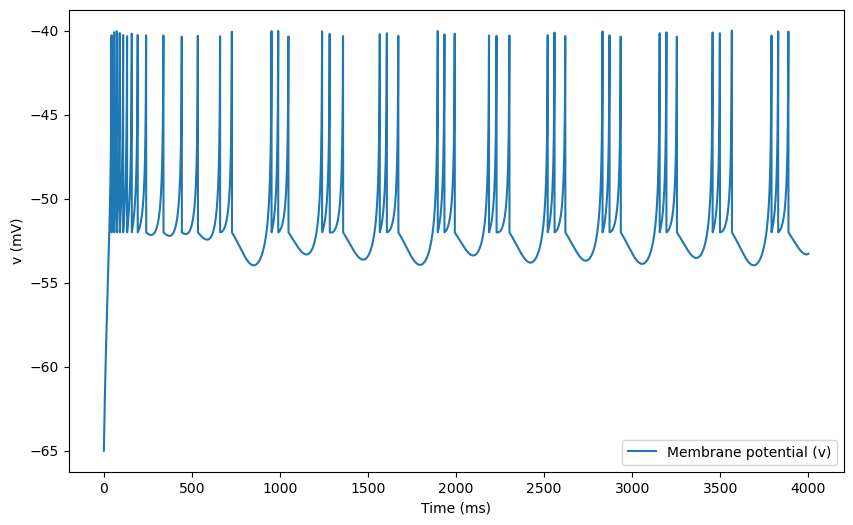

In [14]:
from brian2 import *

# Simulation parameters
start_scope()
DT = 0.1  # Time step
defaultclock.dt = DT * ms
duration = 4000 * ms  # Total duration

# Equations
eqs = '''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is: ampere
Ig: ampere
Cm: farad
gl: siemens
El: volt
a: siemens
tau_w: second
Dt: volt
Vt: volt
Ee: volt
Ei: volt
Tsyn: second
'''

# Create a single population of neurons
G = NeuronGroup(1, eqs, threshold='v > -40*mV', reset='v = -52*mV; w += 10*pA', method='euler')
G.v = -65 * mV
G.w = 0.0 * pA
G.GsynE = 0.0 * nS
G.GsynI = 0.0 * nS

# Define parameters
G.Cm = 200. * pF
G.gl = 10. * nS
G.El = -65. * mV
G.Vt = -55. * mV
G.Dt = 5. * mV
G.tau_w = 500. * ms
G.a = 2. * nS
G.Is = 0.120 * nA
G.Ee = 0. * mV
G.Ei = -80. * mV
G.Tsyn = 5. * ms

# Monitoring
M = StateMonitor(G, ['v', 'w'], record=True)
spikes = SpikeMonitor(G)

# Run simulation
run(duration)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(M.t/ms, M.v[0]/mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()


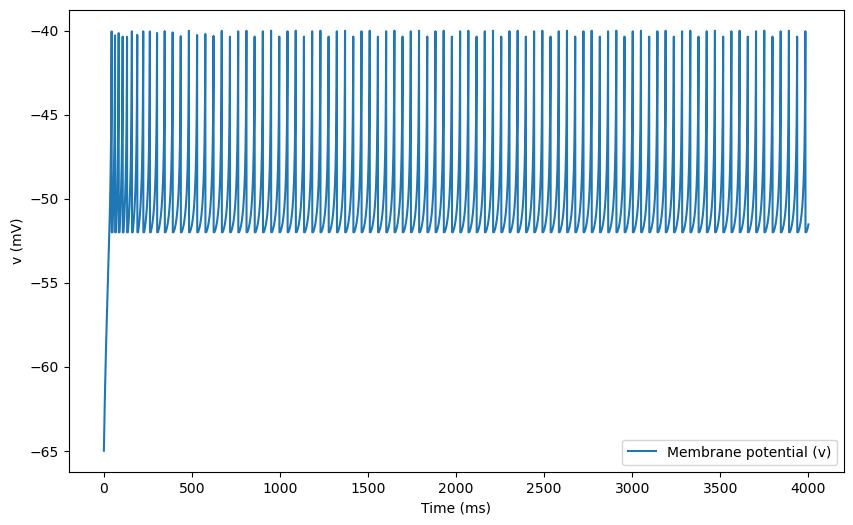

In [15]:
from brian2 import *

# Simulation parameters
start_scope()
DT = 0.1  # Time step
defaultclock.dt = DT * ms
duration = 4000 * ms  # Total duration

# Define neuron model equations
eqs = '''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is: ampere
Ig: ampere
Cm: farad
gl: siemens
El: volt
a: siemens
tau_w: second
Dt: volt
Vt: volt
Ee: volt
Ei: volt
Tsyn: second
'''

# Create a single neuron population
G = NeuronGroup(1, eqs, threshold='v > -40*mV', reset='v = -52*mV; w += 10*pA', refractory=5*ms, method='euler')

# Initialize variables directly within the group
G.v = -65 * mV
G.w = 0.0 * pA
G.GsynE = 0.0 * nS
G.GsynI = 0.0 * nS

# Assign parameters directly to the group
G.Cm = 200. * pF
G.gl = 10. * nS
G.El = -65. * mV
G.Vt = -55. * mV
G.Dt = 5. * mV
G.tau_w = 200. * ms
G.a = 2. * nS
G.Is = 0.120 * nA
G.Ee = 0. * mV
G.Ei = -80. * mV
G.Tsyn = 5. * ms

# Monitoring
M = StateMonitor(G, ['v', 'w'], record=True)
spikes = SpikeMonitor(G)

# Run simulation
run(duration)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(M.t/ms, M.v[0]/mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()


--## Start simulation ##--


WARNING    'Cm' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with the value 200. * pfarad. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ee' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ei' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with the value -80. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'El' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with the value -65. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with

--## End simulation ##--


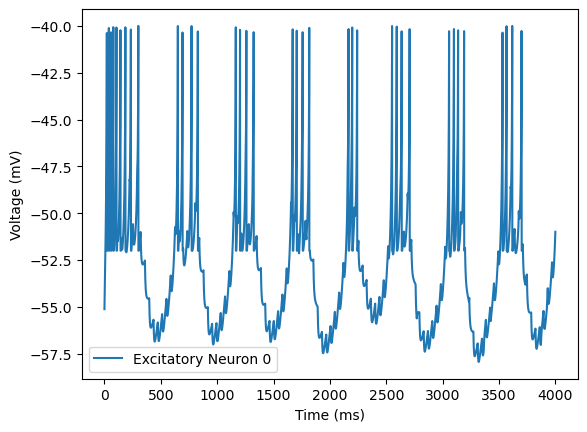

In [16]:
from brian2 import *
import random
%matplotlib inline

# Simulation conditions
start_scope()

DT = 0.1  # Time step
defaultclock.dt = DT * ms
Nb1 = 2  # Number of inhibitory neurons
Nb2 = 2  # Number of excitatory neurons

TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

# Equations
eqs = '''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

# Populations

# Inhibitory neurons
if Nb1 != 0:
    G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
    
    for k in range(len(G_inh.v)):
        G_inh.v[k] = random.uniform(-55, -65) * mV
    G_inh.w = 0.0 * pA
    G_inh.GsynI = 0.0 * nS
    G_inh.GsynE = 0.0 * nS

    # Parameter values
    b1 = 0.0 * pA
    G_inh.Cm = 200. * pF
    G_inh.gl = 10. * nS
    G_inh.El = -65. * mV
    G_inh.Vt = -55. * mV
    G_inh.Dt = 5.0 * mV
    G_inh.tau_w = 500.0 * ms
    G_inh.a = 0.0 * nS
    G_inh.Is = 0.06 * nA
    G_inh.Ee = 0. * mV
    G_inh.Ei = -80. * mV
    G_inh.Tsyn = 5. * ms

# Excitatory neurons
if Nb2 != 0:
    G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
    
    for k in range(len(G_exc.v)):
        G_exc.v[k] = random.uniform(-55, -65) * mV
    G_exc.w = 0.0 * pA
    G_exc.GsynI = 0.0 * nS
    G_exc.GsynE = 0.0 * nS

    # Parameter values
    b2 = 10. * pA
    G_exc.Cm = 200. * pF
    G_exc.gl = 10. * nS
    G_exc.El = -65. * mV
    G_exc.Vt = -55. * mV
    G_exc.Dt = 5.0 * mV
    G_exc.tau_w = 500.0 * ms
    G_exc.a = 2.0 * nS
    G_exc.Is = 0.12 * nA
    G_exc.Ee = 0. * mV
    G_exc.Ei = -80. * mV
    G_exc.Tsyn = 5. * ms

# Synapses
Qi = 1.5 * nS
Qe = 0.5 * nS

if Nb1 != 0:
    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect(p=1)

if Nb2 != 0:
    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect(p=1)

if Nb1 != 0 and Nb2 != 0:
    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect(p=1)
    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect(p=1)

# Monitors
if Nb1 != 0:
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

if Nb2 != 0:
    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

# Run simulation
print('--## Start simulation ##--')
run(duration)
print('--## End simulation ##--')

# Example plotting (excitation group voltage)
if Nb2 != 0:
    plot(M2G2.t / ms, M2G2[0].v / mV, label='Excitatory Neuron 0')
    xlabel('Time (ms)')
    ylabel('Voltage (mV)')
    legend()
    show()


In [22]:
import matplotlib.pyplot as plt
from brian2 import *
import random
import numpy as np

# Assurez-vous que cette ligne est incluse dans Google Colab
%matplotlib notebook 

#########################
# Simulation conditions #
#########################
DT = 0.1  # time step
defaultclock.dt = DT * ms
TotTime = 4000  # Simulation duration (ms)
duration = TotTime * ms

###############
# Equations ###
###############
eqs = '''
# Neuron dynamics:
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is+Ig)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w : ampere
# Model of synapses:
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
# Parameters:
Is : ampere
Ig : ampere
Cm : farad
gl : siemens
El : volt
a : siemens
tau_w : second
Dt : volt
Vt : volt
Ee : volt
Ei : volt
Tsyn : second
'''

##################
# Define a function to initialize and run the simulation for each combination of neurons #
##################
def run_simulation(Nb1, Nb2):
    # Define neuron groups
    if Nb1 != 0:
        G_inh = NeuronGroup(Nb1, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b1', refractory='5*ms', method='heun')
        for k in range(len(G_inh.v)):
            G_inh.v[k] = random.uniform(-55, -65) * mV

        G_inh.w = 0.0 * pA
        G_inh.GsynI = 0.0 * nS
        G_inh.GsynE = 0.0 * nS
        b1 = 0.0 * pA
        G_inh.Cm = 200.0 * pF
        G_inh.gl = 10.0 * nS
        G_inh.El = -65.0 * mV
        G_inh.Vt = -55.0 * mV
        G_inh.Dt = 5.0 * mV
        G_inh.tau_w = 500.0 * ms
        G_inh.a = 0.0 * nS
        G_inh.Is = .06 * nA
        G_inh.Ee = 0.0 * mV
        G_inh.Ei = -80.0 * mV
        G_inh.Tsyn = 5.0 * ms

    if Nb2 != 0:
        G_exc = NeuronGroup(Nb2, eqs, threshold='v > -40.0*mV', reset='v = -52*mV; w += b2', refractory='5*ms', method='heun')
        for k in range(len(G_exc.v)):
            G_exc.v[k] = random.uniform(-55, -65) * mV

        G_exc.w = 0.0 * pA
        G_exc.GsynI = 0.0 * nS
        G_exc.GsynE = 0.0 * nS
        b2 = 10.0 * pA
        G_exc.Cm = 200.0 * pF
        G_exc.gl = 10.0 * nS
        G_exc.El = -65.0 * mV
        G_exc.Vt = -55.0 * mV
        G_exc.Dt = 5.0 * mV
        G_exc.tau_w = 500.0 * ms
        G_exc.a = 2.0 * nS
        G_exc.Is = .120 * nA
        G_exc.Ee = 0.0 * mV
        G_exc.Ei = -80.0 * mV
        G_exc.Tsyn = 5.0 * ms

    ##################
    # Synapses setup #
    ##################
    Qi = 1.5 * nS
    Qe = 0.5 * nS

    if Nb1 != 0:
        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
        S_11.connect(p=1)

    if Nb2 != 0:
        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
        S_22.connect(p=1)

    if Nb1 != 0 and Nb2 != 0:
        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
        S_21.connect(p=1)
        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
        S_12.connect(p=1)

    ##################
    # Recording tools #
    ##################
    M2G1 = StateMonitor(G_inh, 'v', record=range(Nb1))
    M3G1 = StateMonitor(G_inh, 'w', record=range(Nb1))
    M4G1 = StateMonitor(G_inh, 'GsynE', record=range(Nb1))
    M5G1 = StateMonitor(G_inh, 'GsynI', record=range(Nb1))
    M1G1 = SpikeMonitor(G_inh)
    FRG1 = PopulationRateMonitor(G_inh)

    M2G2 = StateMonitor(G_exc, 'v', record=range(Nb2))
    M3G2 = StateMonitor(G_exc, 'w', record=range(Nb2))
    M4G2 = StateMonitor(G_exc, 'GsynE', record=range(Nb2))
    M5G2 = StateMonitor(G_exc, 'GsynI', record=range(Nb2))
    M1G2 = SpikeMonitor(G_exc)
    FRG2 = PopulationRateMonitor(G_exc)

    ##################
    # Run simulation #
    ##################
    print(f'--## Start simulation for Nb1={Nb1} and Nb2={Nb2} ##--')
    run(duration)
    print('--## End simulation ##--')

    ##################
    # Visualization #
    ##################
    # Create the figure
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Plot the data
    ax[0, 0].plot(M2G1.t / ms, M2G1.v / mV, color='r')
    ax[0, 0].set_title("Inhibitory Neurons (Vm)")

    ax[0, 1].plot(M2G2.t / ms, M2G2.v / mV, color='g')
    ax[0, 1].set_title("Excitatory Neurons (Vm)")

    ax[1, 0].plot(M3G1.t / ms, M3G1.w / pA, color='r')
    ax[1, 0].set_title("Inhibitory Neurons (w)")

    ax[1, 1].plot(M3G2.t / ms, M3G2.w / pA, color='g')
    ax[1, 1].set_title("Excitatory Neurons (w)")

    for a in range(len(M2G1.v)):
        ax[0, 0].plot(M2G1.t / ms, M2G1.v[a] / mV, color='r')
    for a in range(len(M2G2.v)):
        ax[0, 1].plot(M2G2.t / ms, M2G2.v[a] / mV, color='g')

    plt.tight_layout()
    plt.show()



In [12]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

start_scope()

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0):
    """Simulates an AdEx network with adjustable sizes and variability in parameters."""
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    Qi, Qe = 5.0, 1.5
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    # Run simulation
    run(duration)

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(FRG_inh.t / ms, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, 'r', label='Inhibitory')
    ax[0].plot(FRG_exc.t / ms, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, 'g', label='Excitatory')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing rate (Hz)')
    ax[0].legend()

    ax[1].hist(FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Excitatory', color='g')
    ax[1].hist(FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Inhibitory', color='r')
    ax[1].set_xlabel('Firing rate (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Interactive exploration
interact(
    simulate_adex_network,
    N_exc=IntSlider(min=100, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=50, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability')
)


interactive(children=(IntSlider(value=8000, description='Excitatory neurons', max=10000, min=100, step=100), I…

<function __main__.simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0)>

In [18]:
print(P2mon[0].P)


[0. 0. 0. ... 0. 0. 0.]


In [14]:
from brian2 import *
import numpy as np
import ipywidgets as widgets
from IPython.display import display

start_scope()

# Fonction pour ajouter du bruit aux paramètres
def add_noise_to_params(Qe, Qi, noise_level=0.1):
    return Qe * (1 + noise_level * np.random.randn()), Qi * (1 + noise_level * np.random.randn())

# Initialisation des paramètres pour explorer différentes tailles de population
def initialize_network(N1, N2, Qe, Qi, noise_level=0.1):
    # Ajouter du bruit aux paramètres Qe et Qi
    Qe, Qi = add_noise_to_params(Qe, Qi, noise_level)

    # Définition des équations
    eqs = """
    dv/dt = (g_iz*(v - E_iz)**2 - u - GsynE*(v - Ee) - GsynI*(v - Ei) + I) / Tv : 1
    du/dt = (a*(b*v - u)) / Tu : 1
    dGsynI/dt = -GsynI / Tsyn : 1
    dGsynE/dt = -GsynE / Tsyn : 1  
    a : 1
    b : 1
    c : 1
    d : 1
    g_iz : 1
    E_iz : 1
    Tsyn : second
    Tv : second
    Tu : second
    Ee : 1
    Ei : 1
    I : 1
    """

    # Population 1 - Neurones inhibiteurs
    G_inh = NeuronGroup(N1, eqs, threshold='v > -30.', reset='v = c; u = u + d', refractory='5*ms', method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0.1
    G_inh.b = 0.2
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.0 * ms
    G_inh.Tv = 1 * second
    G_inh.Tu = 1 * second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.0
    G_inh.I = 0.0
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Neurones excitateurs
    G_exc = NeuronGroup(N2, eqs, threshold='v > -30.', reset='v = c; u = u + d', refractory='5*ms', method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1
    G_exc.b = 0.0
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.0 * ms
    G_exc.Tv = 1 * second
    G_exc.Tu = 1 * second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.0
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # Groupes externes et connexions
    P_ed = PoissonGroup(N2, rates=10.0 * Hz)

    # Connexions synaptiques entre les populations
    prbC = 0.2  # Augmenter la probabilité de connexion

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    # Monitorage des neurones
    M1G_inh = SpikeMonitor(G_inh)
    M1G_exc = SpikeMonitor(G_exc)
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    # Simulation
    run(2000 * ms)  # Augmenter la durée de la simulation

    # Résultats
    return M1G_inh, M1G_exc, FRG_inh, FRG_exc

# Outil interactif pour explorer les dynamiques du réseau avec différentes tailles de populations
def explore_dynamics(N1, N2, Qe, Qi, noise_level=0.1):
    M1G_inh, M1G_exc, FRG_inh, FRG_exc = initialize_network(N1, N2, Qe, Qi, noise_level)

    # Préparation des résultats pour l'affichage
    RasG_inh = np.array([M1G_inh.t/ms, [i + N2 for i in M1G_inh.i]])
    RasG_exc = np.array([M1G_exc.t/ms, M1G_exc.i])

    # Fréquence de tir des populations
    LfrG_inh = np.array(FRG_inh.rate / Hz)
    LfrG_exc = np.array(FRG_exc.rate / Hz)

    # Tracé des résultats
    fig = plt.figure(figsize=(10, 12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.plot(RasG_inh[0], RasG_inh[1], ',r', label='Inhibiteurs')
    ax1.plot(RasG_exc[0], RasG_exc[1], ',g', label='Excitateurs')
    ax1.set_xlabel('Temps (ms)')
    ax1.set_ylabel('Index des neurones')
    ax1.legend()

    ax2.plot(LfrG_inh, 'r', label='Inhibiteurs')
    ax2.plot(LfrG_exc, 'g', label='Excitateurs')
    ax2.set_xlabel('Temps (ms)')
    ax2.set_ylabel('Taux de décharge (Hz)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Widgets interactifs pour changer les paramètres
N1_slider = widgets.IntSlider(value=2000, min=2, max=10000, step=100, description='N1 (Inhibiteurs):')
N2_slider = widgets.IntSlider(value=8000, min=2, max=10000, step=100, description='N2 (Excitateurs):')
Qe_slider = widgets.FloatSlider(value=1.5e-6, min=1e-6, max=3e-6, step=0.1e-6, description='Qe (Courant excitateur):')
Qi_slider = widgets.FloatSlider(value=5e-6, min=1e-6, max=10e-6, step=0.1e-6, description='Qi (Courant inhibiteur):')

interactive_widget = widgets.interactive(explore_dynamics, N1=N1_slider, N2=N2_slider, Qe=Qe_slider, Qi=Qi_slider)
display(interactive_widget)


interactive(children=(IntSlider(value=2000, description='N1 (Inhibiteurs):', max=10000, min=2, step=100), IntS…

--## Start simulation ##--
--## End simulation ##--


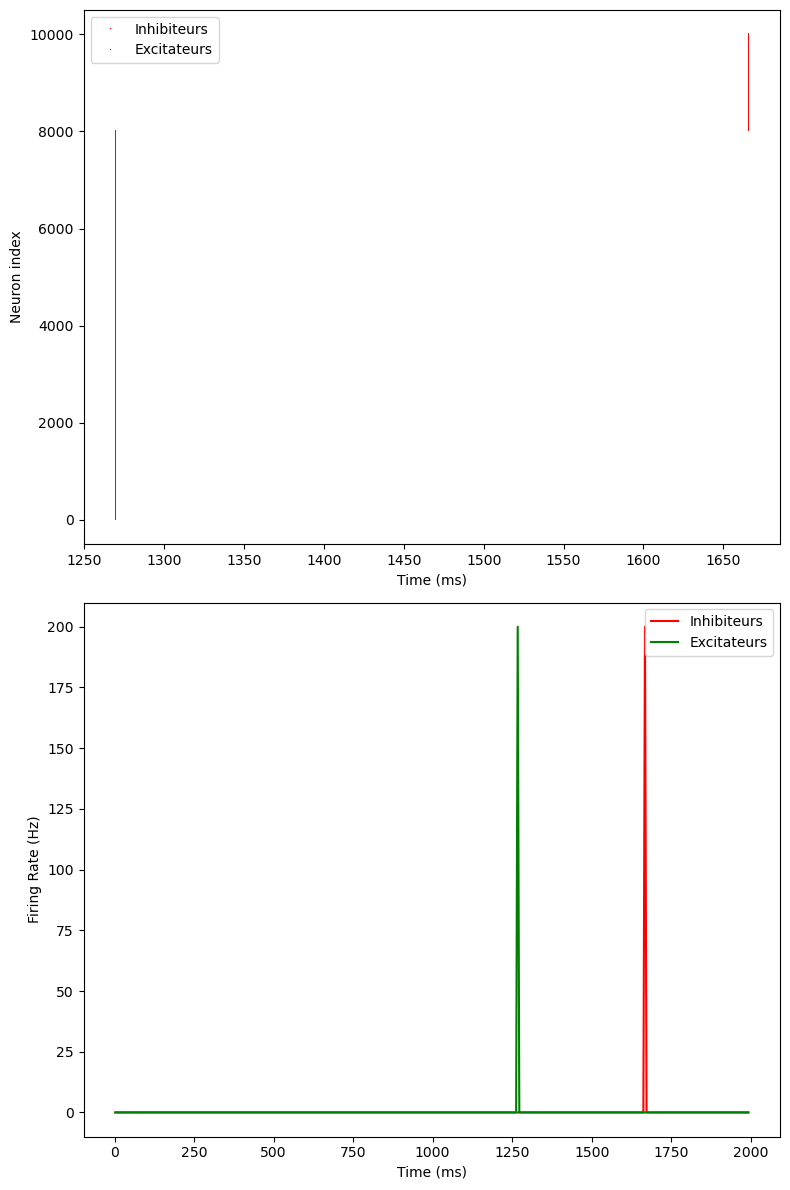

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Définir les paramètres de simulation
start_scope()

DT = 0.1  # pas de temps
defaultclock.dt = DT * ms
N1 = 2000  # Nombre de neurones inhibiteurs
N2 = 8000  # Nombre de neurones excitateurs
TotTime = 2000  # Durée de la simulation (ms)
duration = TotTime * ms

# Définir les équations du modèle
eqs = """
dv/dt = (g_iz*(v - E_iz)**2 - u - GsynE*(v - Ee) - GsynI*(v - Ei) + I) / Tv : 1
du/dt = (a*(b*v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1  
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

# Population 1 - Neurones inhibiteurs
G_inh = NeuronGroup(N1, eqs, threshold='v > -30.', reset='v = c; u = u + d', refractory='5*ms', method='heun')
G_inh.v = -50
G_inh.u = 0
G_inh.a = 0.0
G_inh.b = 0.0
G_inh.c = -55
G_inh.d = 0.0
G_inh.Tsyn = 5.0 * ms
G_inh.Tv = 1 * second
G_inh.Tu = 1 * second
G_inh.Ee = 0.0
G_inh.Ei = -80.0
G_inh.I = 0.0
G_inh.g_iz = 0.04
G_inh.E_iz = -60

# Population 2 - Neurones excitateurs
G_exc = NeuronGroup(N2, eqs, threshold='v > -30.', reset='v = c; u = u + d', refractory='5*ms', method='heun')
G_exc.v = -50
G_exc.u = 0
G_exc.a = 1
G_exc.b = 0.0
G_exc.c = -65
G_exc.d = 15.0
G_exc.Tsyn = 5.0 * ms
G_exc.Tv = 1 * second
G_exc.Tu = 1 * second
G_exc.Ee = 0.0
G_exc.Ei = -80.0
G_exc.I = 0.0
G_exc.g_iz = 0.03
G_exc.E_iz = -65

# Groupe externe
P_ed = PoissonGroup(N2, rates=10.0 * Hz)

# Connexions synaptiques
Qi = 5.0 * 1e-6  # Courant inhibiteur
Qe = 1.5 * 1e-6  # Courant excitateur
prbC = 0.2  # Probabilité de connexion

S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
S_12.connect('i != j', p=prbC)

S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
S_11.connect('i != j', p=prbC)

S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
S_21.connect('i != j', p=prbC)

S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
S_22.connect('i != j', p=prbC)

S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
S_ed_in.connect(p=prbC)

S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
S_ed_ex.connect(p=prbC)

# Enregistrement des données
M1G_inh = SpikeMonitor(G_inh)
FRG_inh = PopulationRateMonitor(G_inh)
M1G_exc = SpikeMonitor(G_exc)
FRG_exc = PopulationRateMonitor(G_exc)

# Surveillance des variables d'état des neurones
M2G1 = StateMonitor(G_inh, 'v', record=range(1))
M3G1 = StateMonitor(G_inh, 'u', record=range(1))
M4G1 = StateMonitor(G_inh, 'GsynE', record=range(1))
M5G1 = StateMonitor(G_inh, 'GsynI', record=range(1))

M2G2 = StateMonitor(G_inh, 'v', record=range(2))
M3G2 = StateMonitor(G_inh, 'u', record=range(2))
M4G2 = StateMonitor(G_inh, 'GsynE', record=range(2))
M5G2 = StateMonitor(G_inh, 'GsynI', record=range(2))

# Exécution de la simulation
print('--## Start simulation ##--')
run(duration)
print('--## End simulation ##--')

# Préparation des résultats
RasG_inh = np.array([M1G_inh.t / ms, [i + N2 for i in M1G_inh.i]])
RasG_exc = np.array([M1G_exc.t / ms, M1G_exc.i])

# Taux de décharge (firing rate)
def bin_array(array, BIN, time_array):
    N0 = int(BIN / (time_array[1] - time_array[0]))
    N1 = int((time_array[-1] - time_array[0]) / BIN)
    return array[:N0 * N1].reshape((N1, N0)).mean(axis=1)

BIN = 5
time_array = np.arange(int(TotTime / DT)) * DT

LfrG_exc = np.array(FRG_exc.rate / Hz)
TimBinned, popRateG_exc = bin_array(time_array, BIN, time_array), bin_array(LfrG_exc, BIN, time_array)

LfrG_inh = np.array(FRG_inh.rate / Hz)
TimBinned, popRateG_inh = bin_array(time_array, BIN, time_array), bin_array(LfrG_inh, BIN, time_array)

# Graphiques
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Tracé des résultats du raster plot
ax1.plot(RasG_inh[0], RasG_inh[1], ',r', label='Inhibiteurs')
ax1.plot(RasG_exc[0], RasG_exc[1], ',g', label='Excitateurs')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Neuron index')
ax1.legend()

# Tracé des taux de décharge
ax2.plot(TimBinned, popRateG_inh, 'r', label='Inhibiteurs')
ax2.plot(TimBinned, popRateG_exc, 'g', label='Excitateurs')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.legend()

# Affichage de l'ensemble des graphiques
plt.tight_layout()
plt.show()


---

# Second Project: Network, Scales, and Measures (On the Nature of Complexity)

In this project, we directly move to the network scale. The goal is to propose a possible description and characterization of the network's activity. To assist with this, an introduction to potential measures is provided (feel free to suggest more!). Here are some guiding questions to stimulate your thinking.

In the provided `Network Brian2.py` code, the network consists of two populations: 80% **Regular Spiking (RS)** and 20% **Fast Spiking (FS)** neudels, representing excitatory and inhibitory neudels, respectively. The total network contains 10,000 neudels. It receives a Poissonian external input of incoming spikes. By changing parameters such as connectivity between populations, the \( b \)-value, or the external input, you can observe different dynamical regimes.

Each neudel is described by 4 variables (2 from the AdEx model and 2 for the synaptic conductance), meaning the system consists of 40,000 equations. Analyzing each variable individually or representing the phase space in 40,000 dimensions becomes impractical. Therefore, we need alternative methods for representing, understanding, and analyzing the dynamics, such as using network-level measures.

## 3.1 Global Measurements of Network Activities

From the network simulation, we can record the evolution of the variables, the mean, and standard deviation of these variables. We can also track events like spikes to generate a **raster plot** and calculate the **average firing rate** over a time window. A key question arises around time averaging: while averaging can simplify the analysis, it may obscure important details depending on the dynamical regimes and the specific goals of the model. We need to consider underlying scales and how averaging affects the interpretation.


In [10]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

start_scope()

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0, Qi=5.0, Qe=1.5):
    """Simulates an AdEx network with adjustable sizes, variability, and synaptic parameters."""
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    State_inh = StateMonitor(G_inh, 'v', record=True)
    State_exc = StateMonitor(G_exc, 'v', record=True)

    # Run simulation
    run(duration)

    # Analyze dynamics
    exc_rate = FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz
    inh_rate = FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz
    synchronization = np.std(exc_rate) / np.mean(exc_rate)

    # Plot results
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))

    ax[0].plot(FRG_inh.t / ms, inh_rate, 'r', label='Inhibitory')
    ax[0].plot(FRG_exc.t / ms, exc_rate, 'g', label='Excitatory')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing rate (Hz)')
    ax[0].legend()

    ax[1].hist(exc_rate, bins=50, alpha=0.7, label='Excitatory', color='g')
    ax[1].hist(inh_rate, bins=50, alpha=0.7, label='Inhibitory', color='r')
    ax[1].set_xlabel('Firing rate (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].legend()

    ax[2].plot(State_exc.t / ms, np.mean(State_exc.v, axis=0), label='Mean Excitatory Potential')
    ax[2].plot(State_inh.t / ms, np.mean(State_inh.v, axis=0), label='Mean Inhibitory Potential', linestyle='dashed')
    ax[2].set_xlabel('Time (ms)')
    ax[2].set_ylabel('Membrane Potential (mV)')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"Synchronization index: {synchronization:.2f}")

# Interactive exploration
interact(
    simulate_adex_network,
    N_exc=IntSlider(min=2, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=2, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability'),
    Qi=FloatSlider(min=1.0, max=10.0, step=0.1, value=5.0, description='IW Qi'),
    Qe=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.5, description='EW Qe')
)


interactive(children=(IntSlider(value=8000, description='Excitatory neurons', max=10000, min=2, step=100), Int…

<function __main__.simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0, Qi=5.0, Qe=1.5)>

In [9]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

start_scope()

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0):
    """Simulates an AdEx network with adjustable sizes and variability in parameters."""
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    Qi, Qe = 5.0, 1.5
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    # Run simulation
    run(duration)

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(FRG_inh.t / ms, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, 'r', label='Inhibitory')
    ax[0].plot(FRG_exc.t / ms, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, 'g', label='Excitatory')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing rate (Hz)')
    ax[0].legend()

    ax[1].hist(FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Excitatory', color='g')
    ax[1].hist(FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Inhibitory', color='r')
    ax[1].set_xlabel('Firing rate (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Interactive exploration
interact(
    simulate_adex_network,
    N_exc=IntSlider(min=100, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=50, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability')
)


interactive(children=(IntSlider(value=8000, description='Excitatory neurons', max=10000, min=100, step=100), I…

<function __main__.simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0)>

In [8]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

start_scope()

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0):
    """Simulates an AdEx network with adjustable sizes and variability in parameters."""
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    Qi, Qe = 5.0, 1.5
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    # Run simulation
    run(duration)

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(FRG_inh.t / ms, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, 'r', label='Inhibitory')
    ax[0].plot(FRG_exc.t / ms, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, 'g', label='Excitatory')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing rate (Hz)')
    ax[0].legend()

    ax[1].hist(FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Excitatory', color='g')
    ax[1].hist(FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, bins=50, alpha=0.7, label='Inhibitory', color='r')
    ax[1].set_xlabel('Firing rate (Hz)')
    ax[1].set_ylabel('Count')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Interactive exploration
interact(
    simulate_adex_network,
    N_exc=IntSlider(min=100, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=50, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability')
)


interactive(children=(IntSlider(value=8000, description='Excitatory neurons', max=10000, min=100, step=100), I…

<function __main__.simulate_adex_network(N_exc=8000, N_inh=2000, variability=0.0)>

## 3. Interprétations : 

### 1. Interactions entre deux types de neurones
- **Deux populations de neurones** sont définies :
  - *G_exc* : Population excitatrice.
  - *G_inh* : Population inhibitrice.
- **Interactions synaptiques** :
  - Les synapses excitatrices ont des poids \(Q_e\), augmentant l'activité post-synaptique.
  - Les synapses inhibitrices ont des poids \(Q_i\), diminuant l'activité post-synaptique.
  - Les connexions entre les neurones sont établies via la classe `Synapses` de Brian2.
  
### 2. Indicateurs pour les régimes dynamiques
- **Visualisations graphiques** :
  - Taux de décharge pour les populations excitatrices et inhibitrices.
  - Histogrammes des fréquences de décharge, identifiant les régimes dynamiques.
- **Calcul d'un indice de synchronisation** :
  - Permet de détecter des régimes synchrones (oscillations) ou désordonnés (chaotiques).

### 3. Évaluation de la robustesse
- **Variabilité aléatoire** :
  - Une variabilité (\(variability\)) ajoutée aux paramètres neuronaux (\(a, b\)) et synaptiques (\(Q_e, Q_i\)).
  - Cela simule des perturbations aléatoires pour tester la robustesse du système.
  
  
  ### Questions and Insights on the Coupled System and Global Dynamics:

1. **What can we say about the coupled system from the single neudel phase portrait?**

   The phase portrait of a single neuron (neudel) provides a visualization of its dynamical behavior with respect to its state variables, such as membrane potential and recovery variable. From the phase portrait of a single neuron, we can understand the following aspects:
   - **Fixed points**: Locations where the system is at equilibrium (no change in the state variables). For a neuron, these are typically stable (resting state) or unstable (firing state).
   - **Limit cycles**: Oscillatory behavior, indicating periodic spiking activity.
   - **Bifurcations**: How changes in parameters (e.g., input currents or synaptic conductance) can lead to qualitative changes in the dynamics, such as transitioning from a stable fixed point to limit cycle oscillations or chaos.

   However, when you move from the single-neuron dynamics to a coupled network, the system's dynamics become more complex. The interactions between neurons will modify the fixed points, limit cycles, and overall behavior. The phase portrait of a single neuron helps us understand the intrinsic properties (e.g., how a neuron fires in isolation), but the full dynamics of the network can lead to phenomena like synchronization, collective oscillations, or chaotic behavior that are not directly visible in the single-neuron phase portrait.

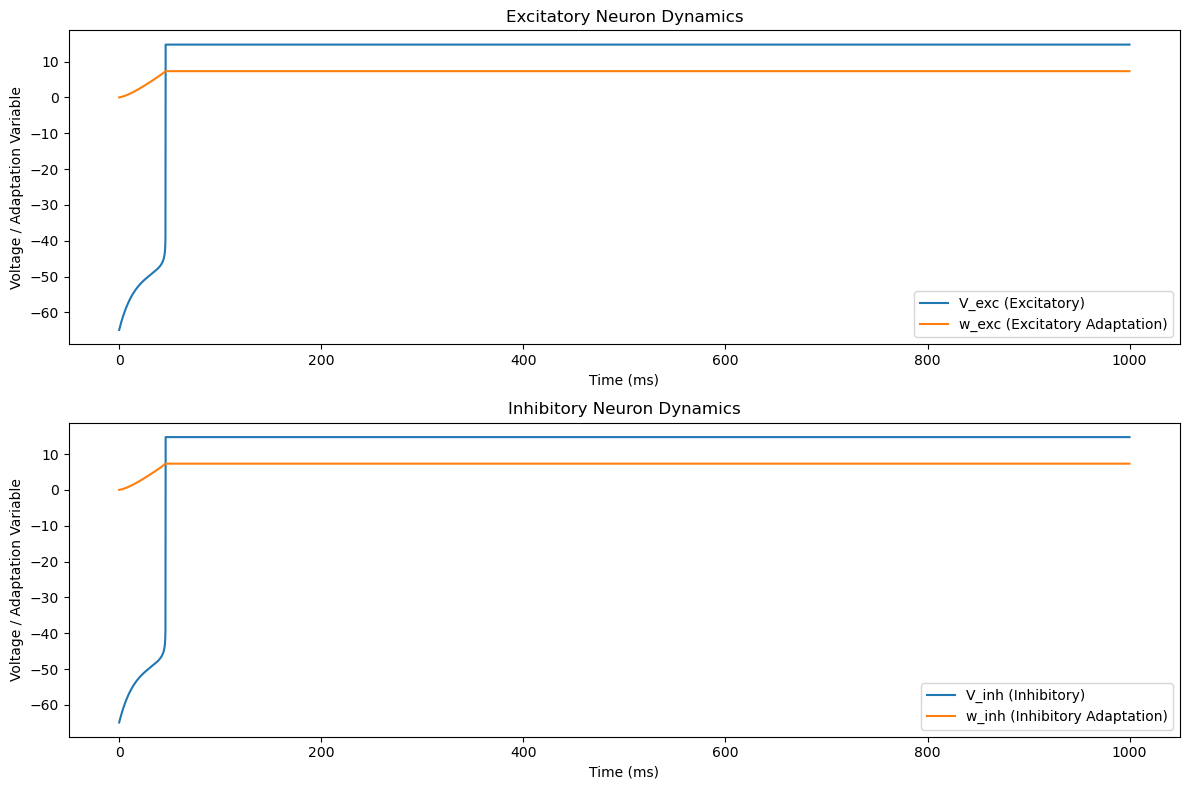

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define parameters for the AdEx model
params = {
    'gL': 10.0,        # Leak conductance (nS)
    'EL': -70.0,       # Leak reversal potential (mV)
    'VT': -50.0,       # Threshold potential (mV)
    'DeltaT': 2.0,     # Slope factor (mV)
    'C': 200.0,        # Membrane capacitance (pF)
    'a': 2.0,          # Subthreshold adaptation (nS)
    'b': 60.0,         # Spike-triggered adaptation (pA)
    'tau_w': 200.0,    # Adaptation time constant (ms)
    'Vr': -65.0,       # Reset potential (mV)
    'Vth': 20.0        # Spike threshold (mV)
}

# Synaptic parameters
syn_params = {
    'Qe': 1.5,   # Excitatory synaptic strength (nS)
    'Qi': 1.5,   # Inhibitory synaptic strength (nS)
    'E_ex': 0.0, # Excitatory reversal potential (mV)
    'E_in': -80.0 # Inhibitory reversal potential (mV)
}

# External current
I_ext = [200.0, 200.0]  # External input current for excitatory and inhibitory neurons

# Define the system of equations for coupled AdEx neurons
def coupled_adex(t, y, params, syn_params):
    V_exc, w_exc, V_inh, w_inh = y

    # Unpack AdEx parameters
    gL, EL, VT, DeltaT, C, a, b, tau_w, Vr, Vth = (
        params['gL'], params['EL'], params['VT'], params['DeltaT'], params['C'],
        params['a'], params['b'], params['tau_w'], params['Vr'], params['Vth']
    )

    # Unpack synaptic parameters
    Qe, Qi, E_ex, E_in = (
        syn_params['Qe'], syn_params['Qi'], syn_params['E_ex'], syn_params['E_in']
    )

    # Synaptic currents
    I_syn_exc = Qe * (E_ex - V_exc) + Qi * (E_in - V_exc)
    I_syn_inh = Qe * (E_ex - V_inh) + Qi * (E_in - V_inh)

    # Equations for excitatory neuron
    dV_exc = (gL * (EL - V_exc) + gL * DeltaT * np.exp((V_exc - VT) / DeltaT) - w_exc + I_ext[0] + I_syn_exc) / C
    dw_exc = (a * (V_exc - EL) - w_exc) / tau_w

    # Equations for inhibitory neuron
    dV_inh = (gL * (EL - V_inh) + gL * DeltaT * np.exp((V_inh - VT) / DeltaT) - w_inh + I_ext[1] + I_syn_inh) / C
    dw_inh = (a * (V_inh - EL) - w_inh) / tau_w

    return [dV_exc, dw_exc, dV_inh, dw_inh]

# Reset mechanism to handle spikes
def handle_resets(y, params):
    V_exc, w_exc, V_inh, w_inh = y
    Vr, Vth, b = params['Vr'], params['Vth'], params['b']

    if V_exc >= Vth:
        V_exc = Vr
        w_exc += b

    if V_inh >= Vth:
        V_inh = Vr
        w_inh += b

    return [V_exc, w_exc, V_inh, w_inh]

# Initial conditions and time vector
initial_conditions = [-65.0, 0.0, -65.0, 0.0]  # [V_exc, w_exc, V_inh, w_inh]
t = np.linspace(0, 1000, 10000)  # Time in ms

# Solve the system using solve_ivp
results = []
current_conditions = initial_conditions
for i in range(len(t) - 1):
    solution = solve_ivp(
        coupled_adex, 
        [t[i], t[i + 1]], 
        current_conditions, 
        method='BDF', 
        args=(params, syn_params), 
        max_step=1.0  # Limit step size for better numerical stability
    )

    # Apply reset mechanism
    current_conditions = handle_resets(solution.y[:, -1], params)

    # Store results
    results.append(current_conditions)

# Convert results to numpy array for plotting
results = np.array(results)
V_exc, w_exc, V_inh, w_inh = results.T

# Plot results
plt.figure(figsize=(12, 8))

# Excitatory neuron
plt.subplot(2, 1, 1)
plt.plot(t[:-1], V_exc, label='V_exc (Excitatory)')
plt.plot(t[:-1], w_exc, label='w_exc (Excitatory Adaptation)')
plt.title('Excitatory Neuron Dynamics')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage / Adaptation Variable')
plt.legend()

# Inhibitory neuron
plt.subplot(2, 1, 2)
plt.plot(t[:-1], V_inh, label='V_inh (Inhibitory)')
plt.plot(t[:-1], w_inh, label='w_inh (Inhibitory Adaptation)')
plt.title('Inhibitory Neuron Dynamics')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage / Adaptation Variable')
plt.legend()

plt.tight_layout()
plt.show()


---

## 3.2 From One to the Whole

If we are interested in spike activity and the potential regimes, measuring the **coefficient of variation** for each neudel and looking at statistical data might be insightful. However, this alone may not fully characterize each neudel’s contribution to the entire system. One alternative is to explore the **correlations** between individual and global measures. Of course, other ways of characterizing the network activity are also possible, and should be explored.

## 3.3 General Questions

- What can we call the network's "behavior"? What can we measure in the network, and how?
- Can we observe correlations between the measures?
- What information do we lose by averaging, and what information do we want to preserve?
- How does the activity of a single neudel relate to the global behavior of the network?
- Does the relationship depend on the global dynamical regime?

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from scipy.stats import pearsonr

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def correlation_analysis(N_exc=8000, N_inh=2000, variability=0.0, Qi=5.0, Qe=1.5):
    """Simulates the network and performs correlation analysis between individual neuron activity and global network measures."""
    
    # 1. Create excitatory and inhibitory populations (as before)
    
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    State_inh = StateMonitor(G_inh, 'v', record=True)
    State_exc = StateMonitor(G_exc, 'v', record=True)

    # Run simulation
    run(duration)

    # 2. Calculate ISIs and CV for each neuron
    def calculate_cv(spike_times):
        """Calculate the coefficient of variation (CV) for a list of spike times."""
        ISIs = np.diff(spike_times)
        if len(ISIs) > 1:  # To avoid division by zero
            return np.std(ISIs) / np.mean(ISIs)
        else:
            return np.nan  # Not enough spikes for CV
    
    # Get spike times from the StateMonitors
    spike_times_inh = [State_inh.t[State_inh.v[:, i] > -30.] for i in range(N_inh)]
    spike_times_exc = [State_exc.t[State_exc.v[:, i] > -30.] for i in range(N_exc)]
    
    # Calculate CV for each neuron
    cv_inh = np.array([calculate_cv(st) for st in spike_times_inh])
    cv_exc = np.array([calculate_cv(st) for st in spike_times_exc])
    
    # 3. Calculate global measures
    exc_rate = FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz
    inh_rate = FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz
    synchronization = np.std(exc_rate) / np.mean(exc_rate)
    
    # 4. Correlation between individual CV and global network activity
    # You could calculate correlations with the firing rates or synchronization
    global_rate_exc = np.mean(exc_rate)
    global_rate_inh = np.mean(inh_rate)
    
    # Correlation between CV of excitatory neurons and global firing rate of excitatory neurons
    corr_cv_exc_global = pearsonr(cv_exc, np.full_like(cv_exc, global_rate_exc))
    
    # Correlation between CV of inhibitory neurons and global firing rate of inhibitory neurons
    corr_cv_inh_global = pearsonr(cv_inh, np.full_like(cv_inh, global_rate_inh))
    
    # 5. Plot results
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))

    # Plot Firing rates
    ax[0].plot(FRG_inh.t / ms, inh_rate, 'r', label='Inhibitory')
    ax[0].plot(FRG_exc.t / ms, exc_rate, 'g', label='Excitatory')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing rate (Hz)')
    ax[0].legend()

    # Plot CV distribution
    ax[1].hist(cv_exc, bins=50, alpha=0.7, label='Excitatory', color='g')
    ax[1].hist(cv_inh, bins=50, alpha=0.7, label='Inhibitory', color='r')
    ax[1].set_xlabel('Coefficient of Variation (CV)')
    ax[1].set_ylabel('Count')
    ax[1].legend()

    # Plot correlation between individual CV and global firing rates
    ax[2].scatter(cv_exc, np.full_like(cv_exc, global_rate_exc), label=f'Corr CV Exc - Global Rate: {corr_cv_exc_global[0]:.2f}')
    ax[2].scatter(cv_inh, np.full_like(cv_inh, global_rate_inh), label=f'Corr CV Inh - Global Rate: {corr_cv_inh_global[0]:.2f}')
    ax[2].set_xlabel('CV')
    ax[2].set_ylabel('Global Firing Rate (Hz)')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print(f"Correlation between CV of excitatory neurons and global excitatory firing rate: {corr_cv_exc_global[0]:.2f}")
    print(f"Correlation between CV of inhibitory neurons and global inhibitory firing rate: {corr_cv_inh_global[0]:.2f}")
    
# Interactive exploration
interact(
    correlation_analysis,
    N_exc=IntSlider(min=2, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=2, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability'),
    Qi=FloatSlider(min=1.0, max=10.0, step=0.1, value=5.0, description='IW Qi'),
    Qe=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.5, description='EW Qe')
)


In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

start_scope()

# Simulation parameters
DT = 0.1  # time step (ms)
defaultclock.dt = DT * ms
TotTime = 1000  # Simulation duration (ms)
duration = TotTime * ms

# Neuron model equations
neuron_eqs = """
dv/dt = (g_iz * (v - E_iz)**2 - u - GsynE * (v - Ee) - GsynI * (v - Ei) + I) / Tv : 1 (unless refractory)
du/dt = (a * (b * v - u)) / Tu : 1
dGsynI/dt = -GsynI / Tsyn : 1
dGsynE/dt = -GsynE / Tsyn : 1
a : 1
b : 1
c : 1
d : 1
g_iz : 1
E_iz : 1
Tsyn : second
Tv : second
Tu : second
Ee : 1
Ei : 1
I : 1
"""

def correlation_analysis(N_exc=8000, N_inh=2000, variability=0.0, Qi=5.0, Qe=1.5):
    """Simulates an AdEx network with adjustable sizes, variability, and synaptic parameters, and performs correlation analysis."""
    # Population 1 - Fast Spiking (Inhibitory)
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_inh.v = -50
    G_inh.u = 0
    G_inh.a = 0 + variability * np.random.randn(N_inh)
    G_inh.b = 0 + variability * np.random.randn(N_inh)
    G_inh.c = -55
    G_inh.d = 0.0
    G_inh.Tsyn = 5.*ms
    G_inh.Tv = 1*second
    G_inh.Tu = 1*second
    G_inh.Ee = 0.0
    G_inh.Ei = -80.
    G_inh.I = 0.
    G_inh.g_iz = 0.04
    G_inh.E_iz = -60

    # Population 2 - Regular Spiking (Excitatory)
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = c; u += d', refractory=5*ms, method='heun')
    G_exc.v = -50
    G_exc.u = 0
    G_exc.a = 1 + variability * np.random.randn(N_exc)
    G_exc.b = 0.2 + variability * np.random.randn(N_exc)
    G_exc.c = -65
    G_exc.d = 15.0
    G_exc.Tsyn = 5.*ms
    G_exc.Tv = 1*second
    G_exc.Tu = 1*second
    G_exc.Ee = 0.0
    G_exc.Ei = -80.
    G_exc.I = 0.0
    G_exc.g_iz = 0.03
    G_exc.E_iz = -65

    # External drive
    P_ed = PoissonGroup(N_exc, rates=10.0*Hz)

    # Synapses
    prbC = 0.05

    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect('i != j', p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect('i != j', p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect('i != j', p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect('i != j', p=prbC)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post += Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post += Qe')
    S_ed_ex.connect(p=prbC)

    # Monitors
    FRG_inh = PopulationRateMonitor(G_inh)
    FRG_exc = PopulationRateMonitor(G_exc)

    State_inh = StateMonitor(G_inh, 'v', record=True)
    State_exc = StateMonitor(G_exc, 'v', record=True)

    # Create the Network object
    network = Network(G_inh, G_exc, S_12, S_11, S_21, S_22, S_ed_in, S_ed_ex, FRG_inh, FRG_exc, State_inh, State_exc)

    # Run simulation
    network.run(duration)

    # Calculate ISIs and CV for each neuron
    def calculate_cv(spike_times):
        isi = np.diff(spike_times)
        cv = np.std(isi) / np.mean(isi) if len(isi) > 1 else 0
        return cv

    # Extract spike times
    spike_times_inh = State_inh.t[State_inh.v > -30 * mV]
    spike_times_exc = State_exc.t[State_exc.v > -30 * mV]

    # Calculate CV for each population
    cv_inh = np.array([calculate_cv(spike_times_inh[i]) for i in range(N_inh)])
    cv_exc = np.array([calculate_cv(spike_times_exc[i]) for i in range(N_exc)])

    # Global measures: firing rate
    firing_rate_inh = FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz
    firing_rate_exc = FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz

    # Calculate correlations between individual neuron CV and global firing rates
    correlation_inh = np.corrcoef(cv_inh, firing_rate_inh[:len(cv_inh)])[0, 1]
    correlation_exc = np.corrcoef(cv_exc, firing_rate_exc[:len(cv_exc)])[0, 1]

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(FRG_inh.t / ms, firing_rate_inh, label='Inhibitory Firing Rate')
    ax[0].plot(FRG_exc.t / ms, firing_rate_exc, label='Excitatory Firing Rate')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Firing Rate (Hz)')
    ax[0].legend()

    ax[1].scatter(cv_inh, firing_rate_inh[:len(cv_inh)], label='Inhibitory CV vs Firing Rate')
    ax[1].scatter(cv_exc, firing_rate_exc[:len(cv_exc)], label='Excitatory CV vs Firing Rate')
    ax[1].set_xlabel('CV (Coefficient of Variation)')
    ax[1].set_ylabel('Firing Rate (Hz)')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"Inhibitory CV vs Firing Rate Correlation: {correlation_inh:.2f}")
    print(f"Excitatory CV vs Firing Rate Correlation: {correlation_exc:.2f}")

# Interactive exploration
interact(
    correlation_analysis,
    N_exc=IntSlider(min=2, max=10000, step=100, value=8000, description='Excitatory neurons'),
    N_inh=IntSlider(min=2, max=5000, step=50, value=2000, description='Inhibitory neurons'),
    variability=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Variability'),
    Qi=FloatSlider(min=1.0, max=10.0, step=0.1, value=5.0, description='IW Qi'),
    Qe=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.5, description='EW Qe')
)


In [ ]:
def visualize_correlations_and_isi(G_exc, G_inh, State_inh, State_exc, FRG_inh, FRG_exc):
    """
    Visualize the correlation between the firing rates and individual neuron activity.
    Also compares ISI distributions for individual neurons vs. global network activity.
    """
    # 1. Correlation between firing rate and CV (individual neuron activity)
    cv_inh = np.array([calculate_cv(State_inh.t[State_inh.v[:,i] > -30*mv]) for i in range(len(State_inh.v[0]))])
    cv_exc = np.array([calculate_cv(State_exc.t[State_exc.v[:,i] > -30*mv]) for i in range(len(State_exc.v[0]))])
    
    correlation_inh = np.corrcoef(cv_inh, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz)[0, 1]
    correlation_exc = np.corrcoef(cv_exc, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz)[0, 1]

    print(f"Inhibitory CV vs Firing Rate Correlation: {correlation_inh:.2f}")
    print(f"Excitatory CV vs Firing Rate Correlation: {correlation_exc:.2f}")
    
    # 2. ISI Distributions
    isi_inh = np.array([np.diff(State_inh.t[State_inh.v[:, i] > -30*mv]) for i in range(len(State_inh.v[0]))])
    isi_exc = np.array([np.diff(State_exc.t[State_exc.v[:, i] > -30*mv]) for i in range(len(State_exc.v[0]))])

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(isi_inh.flatten(), bins=50, alpha=0.6, label="Inhibitory Neurons")
    plt.hist(isi_exc.flatten(), bins=50, alpha=0.6, label="Excitatory Neurons")
    plt.xlabel('ISI (ms)')
    plt.ylabel('Frequency')
    plt.title('ISI Distribution for Individual Neurons')
    plt.legend()

    # Global network ISI distribution
    isi_network = np.diff(np.concatenate([State_inh.t, State_exc.t]))  # Combine both populations
    plt.subplot(1, 2, 2)
    plt.hist(isi_network, bins=50, alpha=0.6, label="Network (Exc + Inh)")
    plt.xlabel('ISI (ms)')
    plt.ylabel('Frequency')
    plt.title('ISI Distribution for Network')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appeler la fonction dans votre simulation
visualize_correlations_and_isi(G_exc, G_inh, State_inh, State_exc, FRG_inh, FRG_exc)


## Explanations :

### Exploring Network Behavior

#### 1. What Can We Call the Network "Behavior"? What Can We Measure in the Network? How?

The **network behavior** refers to the collective dynamics of neurons, such as synchronization, spiking activity, oscillations, or emergent patterns. Key measurable properties include:

- **Firing Rate:**
  - **Definition:** Average number of spikes per unit time across neurons.
  - **How:** Use a `PopulationRateMonitor` or compute spike counts from raster plots.
  - **Insights:** Indicates excitability, inhibition levels, and overall network activity.

- **Spike Synchronization:**
  - **Definition:** Extent to which spikes occur at the same time across neurons.
  - **How:** Calculate the standard deviation or coefficient of variation (CV) of population firing rates, or use pairwise correlations between spike trains.
  - **Insights:** Helps classify network regimes (e.g., asynchronous, synchronous, bursting).

- **Raster Plots:**
  - **Definition:** Visual representation of spike times for individual neurons.
  - **How:** Collect spike events using a `SpikeMonitor` and plot spikes over time.
  - **Insights:** Reveals temporal structure (e.g., bursting, rhythmic activity).

- **Membrane Potential Dynamics:**
  - **Definition:** Evolution of average membrane potential across neurons.
  - **How:** Use a `StateMonitor` to record membrane potential (v).
  - **Insights:** Shows subthreshold dynamics, oscillations, or transitions to spiking.

- **Power Spectrum:**
  - **Definition:** Distribution of power across frequency bands of the network activity.
  - **How:** Perform a Fourier transform on the population firing rate.
  - **Insights:** Reveals oscillatory dynamics and dominant frequency bands.

- **Spike-Timing-Dependent Measures:**
  - **Example:** Spike Time Tiling Coefficient (STTC) to analyze precise timing correlations.
  - **Insights:** Captures fine-grained temporal coordination.

---

#### 2. Can We See Correlations Between the Measures?

Yes, many measures are interdependent. Correlations can reveal important properties of the network:

- **Firing Rate ↔ Synchronization:**
  - High synchronization often correlates with bursts of high firing rates.
  - Asynchronous states are characterized by low synchronization and moderate, distributed firing rates.

- **Membrane Potential Dynamics ↔ Firing Rate:**
  - Membrane potential oscillations can drive rhythmic spiking, observable in firing rates.

- **Firing Rate ↔ Power Spectrum:**
  - Peaks in the power spectrum reflect oscillations in population firing rates.

- **Single-Neuron ↔ Population Dynamics:**
  - The activity of a single neuron may align with global oscillatory patterns (phase-locked spiking), or it may diverge in asynchronous regimes.

By plotting one measure against another (e.g., firing rate vs. synchronization), we can uncover transitions between dynamical regimes or emergent behaviors.

---

#### 3. What Information Do We Lose? What Information Do We Want to Keep?

#### **Information Lost:**
- **Precise Spike Timing:** Aggregating spikes into firing rates discards detailed temporal information about individual spike events.
- **Neuron-Specific Activity:** Averaging across populations can obscure heterogeneity among neurons.
- **Subthreshold Dynamics:** Focusing only on spikes misses important membrane potential dynamics.
- **Spatial Structure:** If the network has spatial organization (e.g., layers, connectivity motifs), simple population-level measures may ignore this.

#### **Information We Want to Keep:**
- **Collective Dynamics:** Synchronization, oscillations, and phase relationships.
- **Temporal Correlations:** Between spikes or firing rates over time.
- **Subthreshold Fluctuations:** For understanding transitions between states.
- **Emergent Patterns:** Such as bursts or traveling waves.

---

#### 4. How Does the Activity of a Single Neuron Relate to the Global Behavior of the Network?

The relationship depends on the network's **dynamical regime**:

- **Asynchronous State:**
  - Single-neuron activity is weakly correlated with the population.
  - Spiking is irregular, and neurons behave quasi-independently.
  - Subthreshold activity may still reflect global input fluctuations.

- **Synchronous State:**
  - Single neurons tend to fire in phase with the population rhythm.
  - Oscillatory activity dominates, with individual neurons contributing to or being entrained by the collective rhythm.

- **Bursting or Chaotic States:**
  - Single-neuron spiking may still align with bursts, but the exact timing may vary.
  - Subthreshold dynamics can show rich, chaotic-like variability, reflecting network-level chaos.

- **Excitatory-Inhibitory Balance:**
  - A single neuron’s activity reflects the balance between excitatory and inhibitory inputs.
  - Imbalances can cause transitions in firing behavior, which may propagate through the network.

---

#### 5. Does It Depend on the Global Dynamical Regime?

Yes, the relationship between single-neuron activity and network behavior is highly regime-dependent:

- **Asynchronous Regime:**
  - Low correlation between single-neuron and network activity.
  - Network-level behavior appears as unstructured noise.

- **Oscillatory Regime:**
  - High correlation between single-neuron spiking and population-level oscillations.
  - Neurons are often phase-locked to network rhythms.

- **Critical Regime:**
  - Single-neuron spiking is finely tuned to the network’s critical dynamics.
  - Small changes in single-neuron properties can impact the global state.

- **Chaotic Regime:**
  - Single neurons show sensitive dependence on initial conditions, reflecting network-wide chaos.
  - The relationship is less stable and more difficult to predict.

---

### Experimental Summary

- **Simulation Tools:** Use of `Brian2` or `NEST` to simulate network dynamics.
- **Analysis Methods:**
  - Compute firing rates, CV, and synchronization indices.
  - Use Fourier transforms for spectral analysis.
  - Create raster plots and cross-correlation matrices.
- **Visualization:** Compare time series of single-neuron activity vs. population metrics (e.g., firing rates, mean potentials).


---

# Third Project (Bonus): Comparison Between Models

In this third part (bonus), we propose a comparison between the models: the **AdEx model** described earlier, and the **adaptive quadratic integrate-and-fire (aQIF) model** [2, 3]. These two models share similarities in their phase space. The aQIF model is a variant of the **quadratic integrate-and-fire (QIF)** model, enhanced to include adaptation mechanisms.

The **QIF model** is widely used to model the dynamics of spiking neurons with a simple quadratic nonlinearity. The adaptive component in the **aQIF model** introduces an additional variable to represent slow processes, such as after-spike adaptation or ionic currents [4].

### 3.1 The aQIF Model

In the aQIF model, the dynamics of the membrane potential \( v \) and the adaptation variable \( u \) are governed by the following differential equations:

1. **Membrane potential dynamics:**
   $$
   \tau_v \frac{dv}{dt} = g \left(v - E_{\text{syn}}\right)^2 - u - G_{\text{syn}} \left(v - E_{\text{syn}}\right) + I_{\text{ext}}
   $$

2. **Adaptation variable dynamics:**
   $$
   \tau_u \frac{du}{dt} = a(bv - u)
   $$

where:
- $v$: Membrane potential
- $u$: Adaptation variable
- $g$: Scaling parameter for the quadratic term (associated with conductance)
- $E_{\text{syn}}$: Effective reversal potential of the QIF term
- $G_{\text{synE}}$ and $G_{\text{synI}}$: Synaptic conductances for excitatory and inhibitory synapses, respectively
- $E_e$ and $E_i$: Reversal potentials for excitatory and inhibitory synapses, respectively
- $I$: External input current
- $\tau_v$: Membrane time constant
- $a$, $b$, and $\tau_u$: Parameters controlling adaptation dynamics


### 3.2 General Questions

The task is to:
- **Plot the phase space** of the aQIF model and compare it with the phase space of the AdEx model.
- **Compare the network dynamics** under different parameter conditions for both models.

This comparison will provide insight into the similarities and differences between the two models and their dynamics at the network level.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_phase_space_aqif(g=0.04, E_syn=-60, I_ext=2.0, a=0.1, b=0.2, T_v=10, T_u=100):
    """
    Plot the phase space (v, u) for the aQIF model.
    """
    v = np.linspace(-80, 20, 1000)
    u = np.linspace(-10, 10, 1000)
    V, U = np.meshgrid(v, u)
    
    # aQIF dynamics
    dvdt = g * (V - E_syn)**2 - U + I_ext
    dudt = a * (b * V - U)
    
    plt.figure(figsize=(8, 6))
    plt.contour(V, U, dvdt, levels=[0], colors='blue', linestyles='dashed', label='dv/dt=0')
    plt.contour(V, U, dudt, levels=[0], colors='orange', linestyles='dashed', label='du/dt=0')
    plt.quiver(V, U, dvdt, dudt, scale=500, color='gray', alpha=0.6)
    
    plt.xlabel('Membrane Potential (v)')
    plt.ylabel('Adaptation Variable (u)')
    plt.title('aQIF Phase Space')
    plt.grid()
    plt.legend(['dv/dt=0', 'du/dt=0'])
    plt.show()

def plot_phase_space_adex(I_ext=2.0, a=0.1, b=0.2, T_v=10, T_u=100, V_reset=-65, V_th=-50):
    """
    Plot the phase space (v, w) for the AdEx model.
    """
    v = np.linspace(-80, 20, 1000)
    w = np.linspace(-10, 10, 1000)
    V, W = np.meshgrid(v, w)
    
    # AdEx dynamics
    dvdt = (V - V_reset) * (V - V_th) - W + I_ext
    dwdt = (a * (b * V - W)) / T_u
    
    plt.figure(figsize=(8, 6))
    plt.contour(V, W, dvdt, levels=[0], colors='blue', linestyles='dashed', label='dv/dt=0')
    plt.contour(V, W, dwdt, levels=[0], colors='orange', linestyles='dashed', label='dw/dt=0')
    plt.quiver(V, W, dvdt, dwdt, scale=500, color='gray', alpha=0.6)
    
    plt.xlabel('Membrane Potential (v)')
    plt.ylabel('Adaptation Variable (w)')
    plt.title('AdEx Phase Space')
    plt.grid()
    plt.legend(['dv/dt=0', 'dw/dt=0'])
    plt.show()

# Plot aQIF phase space
plot_phase_space_aqif()

# Plot AdEx phase space
plot_phase_space_adex()


In [ ]:
from brian2 import *

def simulate_network(model='adex', N_exc=8000, N_inh=2000, Qe=1.5, Qi=5.0, duration=1000*ms):
    """
    Simulate network dynamics for AdEx or aQIF models.
    """
    start_scope()
    
    # Common equations for both models
    if model == 'adex':
        neuron_eqs = """
        dv/dt = (v * (v - v_th) - w + I - GsynE * (v - Ee) - GsynI * (v - Ei)) / Tv : 1 (unless refractory)
        dw/dt = (a * (b * v - w)) / Tu : 1
        dGsynI/dt = -GsynI / Tsyn : 1
        dGsynE/dt = -GsynE / Tsyn : 1
        """
    elif model == 'aqif':
        neuron_eqs = """
        dv/dt = (g * (v - E_syn)**2 - w + I - GsynE * (v - Ee) - GsynI * (v - Ei)) / Tv : 1 (unless refractory)
        dw/dt = (a * (b * v - w)) / Tu : 1
        dGsynI/dt = -GsynI / Tsyn : 1
        dGsynE/dt = -GsynE / Tsyn : 1
        """
    
    # Neuron groups
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = -65; w += 5', refractory=5*ms, method='heun')
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = -65; w += 5', refractory=5*ms, method='heun')

    # Initialization
    G_exc.v = -65
    G_exc.w = 0
    G_inh.v = -65
    G_inh.w = 0
    
    G_exc.g = 0.04 if model == 'aqif' else 0
    G_inh.g = 0.04 if model == 'aqif' else 0
    
    # Synapses
    prbC = 0.05
    S_ee = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_ee.connect('i != j', p=prbC)
    
    S_ie = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_ie.connect('i != j', p=prbC)
    
    S_ii = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_ii.connect('i != j', p=prbC)
    
    S_ei = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_ei.connect('i != j', p=prbC)
    
    # Monitors
    FRG_exc = PopulationRateMonitor(G_exc)
    FRG_inh = PopulationRateMonitor(G_inh)
    
    # Run simulation
    run(duration)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(FRG_exc.t / ms, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, label='Excitatory')
    plt.plot(FRG_inh.t / ms, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, label='Inhibitory')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.title(f'{model.upper()} Network Dynamics')
    plt.grid()
    plt.show()

# Simulate and compare AdEx and aQIF models
simulate_network(model='adex')
simulate_network(model='aqif')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Phase Space Plotting Functions
def plot_phase_space_aqif(g=0.04, E_syn=-60, I_ext=2.0, a=0.1, b=0.2, T_v=10, T_u=100):
    """
    Plot the phase space (v, u) for the aQIF model.
    """
    v = np.linspace(-80, 20, 1000)
    u = np.linspace(-10, 10, 1000)
    V, U = np.meshgrid(v, u)

    dvdt = g * (V - E_syn)**2 - U + I_ext
    dudt = a * (b * V - U)

    plt.figure(figsize=(8, 6))
    plt.contour(V, U, dvdt, levels=[0], colors='blue', linestyles='dashed', label='dv/dt=0')
    plt.contour(V, U, dudt, levels=[0], colors='orange', linestyles='dashed', label='du/dt=0')
    plt.quiver(V, U, dvdt, dudt, scale=500, color='gray', alpha=0.6)
    plt.xlabel('Membrane Potential (v)')
    plt.ylabel('Adaptation Variable (u)')
    plt.title('aQIF Phase Space')
    plt.grid()
    plt.legend(['dv/dt=0', 'du/dt=0'])
    plt.show()

def plot_phase_space_adex(I_ext=2.0, a=0.1, b=0.2, T_v=10, T_u=100, V_reset=-65, V_th=-50):
    """
    Plot the phase space (v, w) for the AdEx model.
    """
    v = np.linspace(-80, 20, 1000)
    w = np.linspace(-10, 10, 1000)
    V, W = np.meshgrid(v, w)

    dvdt = (V - V_reset) * (V - V_th) - W + I_ext
    dwdt = (a * (b * V - W)) / T_u

    plt.figure(figsize=(8, 6))
    plt.contour(V, W, dvdt, levels=[0], colors='blue', linestyles='dashed', label='dv/dt=0')
    plt.contour(V, W, dwdt, levels=[0], colors='orange', linestyles='dashed', label='dw/dt=0')
    plt.quiver(V, W, dvdt, dwdt, scale=500, color='gray', alpha=0.6)
    plt.xlabel('Membrane Potential (v)')
    plt.ylabel('Adaptation Variable (w)')
    plt.title('AdEx Phase Space')
    plt.grid()
    plt.legend(['dv/dt=0', 'dw/dt=0'])
    plt.show()

# Plot aQIF and AdEx phase spaces
plot_phase_space_aqif()
plot_phase_space_adex()


In [ ]:
def simulate_network(model='adex', N_exc=8000, N_inh=2000, Qe=1.5, Qi=5.0, duration=1000*ms):
    """
    Simulate network dynamics for AdEx or aQIF models.
    """
    start_scope()

    # Define equations for both models
    if model == 'adex':
        neuron_eqs = """
        dv/dt = (v * (v - v_th) - w + I - GsynE * (v - Ee) - GsynI * (v - Ei)) / Tv : 1 (unless refractory)
        dw/dt = (a * (b * v - w)) / Tu : 1
        dGsynI/dt = -GsynI / Tsyn : 1
        dGsynE/dt = -GsynE / Tsyn : 1
        """
    elif model == 'aqif':
        neuron_eqs = """
        dv/dt = (g * (v - E_syn)**2 - w + I - GsynE * (v - Ee) - GsynI * (v - Ei)) / Tv : 1 (unless refractory)
        dw/dt = (a * (b * v - w)) / Tu : 1
        dGsynI/dt = -GsynI / Tsyn : 1
        dGsynE/dt = -GsynE / Tsyn : 1
        """

    # Neuron groups
    G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > -30.', reset='v = -65; w += 5', refractory=5*ms, method='heun')
    G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > -30.', reset='v = -65; w += 5', refractory=5*ms, method='heun')

    # Initialize variables
    G_exc.v = -65
    G_exc.w = 0
    G_inh.v = -65
    G_inh.w = 0
    if model == 'aqif':
        G_exc.g = 0.04
        G_inh.g = 0.04

    # Synapses
    prbC = 0.05
    S_ee = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_ee.connect('i != j', p=prbC)
    
    S_ie = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_ie.connect('i != j', p=prbC)
    
    S_ii = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_ii.connect('i != j', p=prbC)
    
    S_ei = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_ei.connect('i != j', p=prbC)

    # Monitors
    FRG_exc = PopulationRateMonitor(G_exc)
    FRG_inh = PopulationRateMonitor(G_inh)
    State_exc = StateMonitor(G_exc, 'v', record=True)
    State_inh = StateMonitor(G_inh, 'v', record=True)

    # Run simulation
    run(duration)

    # Plot firing rates
    plt.figure(figsize=(10, 6))
    plt.plot(FRG_exc.t / ms, FRG_exc.smooth_rate(window='flat', width=5*ms) / Hz, label='Excitatory')
    plt.plot(FRG_inh.t / ms, FRG_inh.smooth_rate(window='flat', width=5*ms) / Hz, label='Inhibitory')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    plt.title(f'{model.upper()} Network Dynamics')
    plt.grid()
    plt.show()

    # Plot membrane potentials
    plt.figure(figsize=(10, 6))
    plt.plot(State_exc.t / ms, np.mean(State_exc.v, axis=0), label='Excitatory Membrane Potential')
    plt.plot(State_inh.t / ms, np.mean(State_inh.v, axis=0), label='Inhibitory Membrane Potential', linestyle='dashed')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend()
    plt.title(f'{model.upper()} Membrane Potentials')
    plt.grid()
    plt.show()

# Simulate and compare AdEx and aQIF models
simulate_network(model='adex')
simulate_network(model='aqif')


## Explanations

## 1. Phase Space Analysis
- **Objective:** Plot the phase space of the adaptive quadratic integrate-and-fire (aQIF) model and compare it to that of the adaptive exponential integrate-and-fire (AdEx) model.

### **Steps:**
1. **aQIF Phase Space:**
   - Plot trajectories in the phase space defined by the membrane potential (\(v\)) and the adaptation variable (\(u\)).
   - Identify fixed points, nullclines, and limit cycles to characterize the dynamic regimes (e.g., stable, oscillatory, bursting).

2. **AdEx Phase Space:**
   - Similarly, visualize trajectories in the phase space for the AdEx model.
   - Note key differences in nullcline shapes, dynamic stability, and transitions between firing states.

3. **Comparison:**
   - Discuss similarities (e.g., presence of nullclines) and differences (e.g., sensitivity to parameter changes, bursting behavior).
   - Highlight the role of the nonlinear terms and adaptation mechanisms in shaping the phase space.

### **Key Measures:**
- **Nullclines:** \( \frac{dv}{dt} = 0 \), \( \frac{du}{dt} = 0 \).
- **Stability:** Eigenvalues of the Jacobian matrix at fixed points.
- **Limit Cycles:** Trajectories indicating oscillatory behavior.

---

## 2. Comparison of Network Dynamics

### **Objective:**
Compare the emergent network behavior of the aQIF and AdEx models under varying parameter conditions, focusing on:

1. **Parameter Exploration:**
   - **External Input (\(I\)):** Adjust intensity and variability to study excitatory drive effects.
   - **Adaptation Parameters (\(a, b, \tau_u\)):** Examine their influence on neuron and network dynamics.
   - **Synaptic Parameters (\(G_{\text{synE}}, G_{\text{synI}}, E_{\text{syn}}\)):** Explore the balance between excitatory and inhibitory inputs.

2. **Network Measures:**
   - Firing rates and synchronization levels.
   - Raster plots to analyze spatiotemporal patterns of spiking activity.
   - Power spectrum of network activity to detect oscillatory regimes.

3. **Comparison Metrics:**
   - **Sensitivity to Parameter Changes:** Which model exhibits richer dynamics under small perturbations?
   - **Emergent Dynamics:** E.g., bursting, oscillations, asynchronous states.
   - **Adaptation Effects:** How does the inclusion of adaptation impact firing regularity, synchronization, or chaotic behavior?

### **Experimental Design:**
1. **Simulate Both Models:**
   - Use identical network structures and initial conditions.
   - Test a range of parameter values (e.g., input currents, synaptic weights).

2. **Analyze Outputs:**
   - Compare population firing rates, membrane potentials, and adaptation variables.
   - Quantify synchronization using metrics like the coefficient of variation (CV) or pairwise spike correlations.

3. **Visualize Results:**
   - Overlay raster plots, firing rates, and phase space trajectories for both models.
   - Plot synchronization indices or power spectra to highlight differences.


# OPENING : MEAN_FIELD OR VOLTERRA SERIES, MEMORY & NON-LINEARITY (Bialek et al.,Reading a neural code)

## Added Mean-Field approach:

Extract global variables (mean discharge rate, mean potential) and compare the dynamics obtained through a simplified description based on the mean field.
Implement bifurcation analyses to explore transitions between different regimes.

## Added Volterra models:

Estimate 1st and 2nd order Volterra kernels from simulated data to model nonlinear interactions.
Add modules to analyze the responses of neurons or populations to specific stimuli.
Additional analyses:

Study the effects of synaptic delays and plasticity.
Visualize attractors and synchronization dynamics.


In [ ]:
# -*- coding: utf-8 -*-
"""
Projet 2: Analyse des dynamiques des réseaux neuronaux
- Intégration des approches Mean-Field et des noyaux de Volterra
"""

# Start a new scope to avoid conflicts with previous simulations
start_scope()

# Importation des bibliothèques
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

# Fonction utilitaire pour l'analyse des taux de décharge moyens
def calcul_mean_field(pop_rate, time_array, BIN):
    """
    Moyenne des taux de décharge sur des fenêtres de temps.
    """
    def bin_array(array, BIN, time_array):
        N0 = int(BIN / (time_array[1] - time_array[0]))
        N1 = int((time_array[-1] - time_array[0]) / BIN)
        return array[:N0 * N1].reshape((N1, N0)).mean(axis=1)

    TimBinned, PopRateBinned = bin_array(time_array, BIN, time_array), bin_array(pop_rate, BIN, time_array)
    return TimBinned, PopRateBinned

# Modèle AdEx (utilisé dans le fichier initial)
def simulate_adex_network(N_exc, N_inh, duration, external_drive=4.0):
    """
    Simule un réseau excitateur/inhibiteur basé sur le modèle AdEx.
    """
    DT = 0.1 * ms
    defaultclock.dt = DT

    # Equations du modèle AdEx
    eqs = '''
    dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
    dw/dt = (a*(v-El)-w)/tau_w:ampere
    dGsynI/dt = -GsynI/Tsyn : siemens
    dGsynE/dt = -GsynE/Tsyn : siemens
    Is:ampere
    Cm:farad
    gl:siemens
    El:volt
    a:siemens
    tau_w:second
    Dt:volt
    Vt:volt
    Ee:volt
    Ei:volt
    Tsyn:second
    '''

    # Configuration des populations
    G_exc = NeuronGroup(N_exc, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += 60.*pA', refractory='5*ms', method='heun')
    G_exc.v = -65.*mV
    G_exc.w = 0.0*pA
    G_exc.Cm = 200.*pF
    G_exc.gl = 10.*nS
    G_exc.El = -70.*mV
    G_exc.Vt = -50.*mV
    G_exc.Dt = 2.*mV
    G_exc.tau_w = 1000.*ms
    G_exc.a = 0.*nS
    G_exc.Is = 0.0*nA
    G_exc.Ee = 0.*mV
    G_exc.Ei = -80.*mV
    G_exc.Tsyn = 5.*ms

    G_inh = NeuronGroup(N_inh, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
    G_inh.v = -65.*mV
    G_inh.w = 0.0*pA
    G_inh.Cm = 200.*pF
    G_inh.gl = 10.*nS
    G_inh.El = -65.*mV
    G_inh.Vt = -50.*mV
    G_inh.Dt = 0.5*mV
    G_inh.tau_w = 1.0*ms
    G_inh.a = 0.0*nS
    G_inh.Is = 0.0
    G_inh.Ee = 0.*mV
    G_inh.Ei = -80.*mV
    G_inh.Tsyn = 5.*ms

    # Connexions entre les populations
    Qi, Qe, prbC = 5.0*nS, 1.5*nS, 0.05
    
    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post+=Qi')
    S_12.connect(p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post+=Qi')
    S_11.connect(p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post+=Qe')
    S_21.connect(p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post+=Qe')
    S_22.connect(p=prbC)

    P_ed = PoissonGroup(N_exc, rates=external_drive*Hz)

    S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post+=Qe')
    S_ed_in.connect(p=prbC)

    S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post+=Qe')
    S_ed_ex.connect(p=prbC)

    # Moniteurs pour l’enregistrement
    M_exc = SpikeMonitor(G_exc)
    FR_exc = PopulationRateMonitor(G_exc)

    M_inh = SpikeMonitor(G_inh)
    FR_inh = PopulationRateMonitor(G_inh)

    # Simulation
    print('-- Début simulation AdEx --')
    run(duration)
    print('-- Fin simulation AdEx --')

    return FR_exc, FR_inh

# Exemple de simulation
N_exc, N_inh, duration = 8000, 2000, 1000*ms
FR_exc, FR_inh = simulate_adex_network(N_exc, N_inh, duration)

# Analyse Mean-Field
time_array = np.linspace(0, duration/ms, int(duration/ms / 0.1))
TimBinned, popRateExc = calcul_mean_field(FR_exc.rate/Hz, time_array, BIN=5)
TimBinned, popRateInh = calcul_mean_field(FR_inh.rate/Hz, time_array, BIN=5)

plt.figure(figsize=(10, 6))
plt.plot(TimBinned, popRateExc, label='Excitatory', color='blue')
plt.plot(TimBinned, popRateInh, label='Inhibitory', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Mean-Field Firing Rates')
plt.legend()
plt.show()

def noyaux_volterra(time_series, ordre=2):
    """
    Calcul des noyaux de Volterra d'ordre donné à partir d'une série temporelle.
    """
    from scipy.linalg import toeplitz

    if ordre == 1:
        kernel = np.correlate(time_series, time_series, mode='full') / len(time_series)
        return kernel[kernel.size // 2:]

    elif ordre == 2:
        n = len(time_series)
        kernel = np.zeros((n, n))
        for i in range(n):
            # Calculate cross-correlation with 'full' mode
            full_corr = np.correlate(time_series, np.roll(time_series, i), mode='full') / len(time_series)
            # Extract the central part of the correlation with length n
            center_index = full_corr.size // 2
            kernel[i, :] = full_corr[center_index - n // 2 : center_index + n // 2 + (n % 2)]  # Extract central part
        return kernel[kernel.shape[0] // 2:, kernel.shape[1] // 2:]

        
# Exemple de calcul des noyaux de Volterra
kernel_1 = noyaux_volterra(popRateExc, ordre=1)
kernel_2 = noyaux_volterra(popRateExc, ordre=2)

# Visualisation des noyaux de Volterra
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(kernel_1, label='Noyau d\'ordre 1')
plt.title('Noyau de Volterra - Ordre 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(kernel_2, extent=[0, len(kernel_2), 0, len(kernel_2)], origin='lower', cmap='hot', aspect='auto')
plt.title('Noyau de Volterra - Ordre 2')
plt.colorbar(label='Amplitude')
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
Projet 2: Analyse des dynamiques des réseaux neuronaux
- Intégration des approches Mean-Field, des noyaux de Volterra et des modèles AdEx et QIF
"""

# Importation des bibliothèques
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

# Fonction utilitaire pour l'analyse des taux de décharge moyens
def calcul_mean_field(pop_rate, time_array, BIN):
    """
    Moyenne des taux de décharge sur des fenêtres de temps.
    """
    def bin_array(array, BIN, time_array):
        N0 = int(BIN / (time_array[1] - time_array[0]))
        N1 = int((time_array[-1] - time_array[0]) / BIN)
        return array[:N0 * N1].reshape((N1, N0)).mean(axis=1)

    TimBinned, PopRateBinned = bin_array(time_array, BIN, time_array), bin_array(pop_rate, BIN, time_array)
    return TimBinned, PopRateBinned

# Modèle QIF (Quadratic Integrate-and-Fire)
def simulate_qif_network(N_exc, N_inh, duration, external_drive=4.0):
    """
    Simule un réseau excitateur/inhibiteur basé sur le modèle QIF.
    """
    DT = 0.1 * ms
    defaultclock.dt = DT

    # Equations du modèle QIF
    eqs = '''
    dv/dt = (v**2 + I - GsynE*(v-Ee) - GsynI*(v-Ei)) / tau_m : volt (unless refractory)
    dGsynE/dt = -GsynE / Tsyn : siemens
    dGsynI/dt = -GsynI / Tsyn : siemens
    I : volt
    tau_m : second
    Ee : volt
    Ei : volt
    Tsyn : second
    '''

    # Configuration des populations
    G_exc = NeuronGroup(N_exc, eqs, threshold='v > 1.*volt', reset='v = -1.*volt', refractory='2*ms', method='euler')
    G_exc.v = '-1 + 2 * rand() * volt'
    G_exc.I = 'external_drive * mV'
    G_exc.tau_m = 20*ms
    G_exc.Ee = 0*mV
    G_exc.Ei = -80*mV
    G_exc.Tsyn = 5*ms

    G_inh = NeuronGroup(N_inh, eqs, threshold='v > 1.*volt', reset='v = -1.*volt', refractory='2*ms', method='euler')
    G_inh.v = '-1 + 2 * rand() * volt'
    G_inh.I = 'external_drive * mV'
    G_inh.tau_m = 10*ms
    G_inh.Ee = 0*mV
    G_inh.Ei = -80*mV
    G_inh.Tsyn = 5*ms

    # Connexions entre les populations
    Qi, Qe, prbC = 5.0*nS, 1.5*nS, 0.05
    
    S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post += Qi')
    S_12.connect(p=prbC)

    S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post += Qi')
    S_11.connect(p=prbC)

    S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post += Qe')
    S_21.connect(p=prbC)

    S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post += Qe')
    S_22.connect(p=prbC)

    # Moniteurs pour l’enregistrement
    M_exc = SpikeMonitor(G_exc)
    FR_exc = PopulationRateMonitor(G_exc)

    M_inh = SpikeMonitor(G_inh)
    FR_inh = PopulationRateMonitor(G_inh)

    # Simulation
    print('-- Début simulation QIF --')
    run(duration)
    print('-- Fin simulation QIF --')

    return FR_exc, FR_inh

# Simulation des réseaux AdEx et QIF
N_exc, N_inh, duration = 8000, 2000, 1000*ms
FR_exc_adex, FR_inh_adex = simulate_adex_network(N_exc, N_inh, duration)
FR_exc_qif, FR_inh_qif = simulate_qif_network(N_exc, N_inh, duration)

# Analyse Mean-Field pour AdEx
time_array = np.linspace(0, duration/ms, int(duration/ms / 0.1))
TimBinned_adex, popRateExc_adex = calcul_mean_field(FR_exc_adex.rate/Hz, time_array, BIN=5)
TimBinned_adex, popRateInh_adex = calcul_mean_field(FR_inh_adex.rate/Hz, time_array, BIN=5)

# Analyse Mean-Field pour QIF
TimBinned_qif, popRateExc_qif = calcul_mean_field(FR_exc_qif.rate/Hz, time_array, BIN=5)
TimBinned_qif, popRateInh_qif = calcul_mean_field(FR_inh_qif.rate/Hz, time_array, BIN=5)

# Visualisation des taux de décharge moyens
plt.figure(figsize=(12, 8))

# AdEx
plt.subplot(2, 1, 1)
plt.plot(TimBinned_adex, popRateExc_adex, label='Excitatory (AdEx)', color='blue')
plt.plot(TimBinned_adex, popRateInh_adex, label='Inhibitory (AdEx)', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Mean-Field Firing Rates - AdEx')
plt.legend()

# QIF
plt.subplot(2, 1, 2)
plt.plot(TimBinned_qif, popRateExc_qif, label='Excitatory (QIF)', color='green')
plt.plot(TimBinned_qif, popRateInh_qif, label='Inhibitory (QIF)', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Mean-Field Firing Rates - QIF')
plt.legend()

plt.tight_layout()
plt.show()

# Intégration des noyaux de Volterra
def noyaux_volterra(time_series, ordre=2):
    """
    Calcul des noyaux de Volterra d'ordre donné à partir d'une série temporelle.
    """
    from scipy.linalg import toeplitz

    if ordre == 1:
        kernel = np.correlate(time_series, time_series, mode='full') / len(time_series)
        return kernel[kernel.size // 2:]

    elif ordre == 2:
        n = len(time_series)
        kernel = np.zeros((n, n))
        for i in range(n):
            kernel[i, :] = np.correlate(time_series, np.roll(time_series, i), mode='full') / len(time_series)
        return kernel[kernel.shape[0] // 2:, kernel.shape[1] // 2:]

# Exemple de calcul des noyaux de Volterra pour AdEx
kernel_1_adex = noyaux_volterra(popRateExc_adex, ordre=1)
kernel_2_adex = noyaux_volterra(popRateExc_adex, ordre=2)

# Exemple de calcul des noyaux de Volterra pour QIF
kernel_1_qif = noyaux_volterra(popRateExc_qif, ordre=1)
kernel_2_qif = noyaux_volterra(popRateExc_qif, ordre=2)

# Visualisation des noyaux de Volterra
plt.figure(figsize=(14, 8))

# AdEx
plt.subplot(2, 2, 1)
plt.plot(kernel_1_adex, label='Noyau d'ordre 1 (AdEx)')
plt.title('Noyau de Volterra - Ordre 1 (AdEx)')
plt.legend()

plt.subplot(2, 2, 2)
plt.imshow(kernel_2_adex, extent=[0, len(kernel_2_adex), 0, len(kernel_2_adex)], origin='lower', cmap='hot', aspect='auto')
plt.title('Noyau de Volterra - Ordre 2 (AdEx)
